# EDA and Modeling of Housing Prices in Ames, IA

The research question of interest is to accurately predict a house's sale price in Ames, IA based upon 79 possible features. The resulting model can be used by buyers, sellers, and realtors to obtain an estimate (with a confidence interval) of what a house is worth. 

In [159]:
# Libraries
import copy
import os 

import pandas as pd
import numpy as np
from scipy.stats import skew

%run functions.ipynb

from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import missingno as msno
import seaborn as sn

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm

## Ingest

Ames, IA housing prices and related features for each sale from [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [160]:
train = pd.read_csv('https://raw.githubusercontent.com/jhancuch/housing-prices-ames-ia/main/data/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/jhancuch/housing-prices-ames-ia/main/data/test.csv')

First five and last five rows of both the training set and test set

In [161]:
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [162]:
train.tail()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
1455         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1456         Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
1457         Lvl    AllPub  ...        0    NaN  GdPrv        Shed    2500   
1458         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1459         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
1455      8   2007        WD         Normal     175000  
1456      2   2010        WD         Normal     210000  
1457      5   2010        WD         Normal     266500  
1458      4   2010        WD         Normal     142125  
1459      6   2008        WD         Normal     147500  

[5 rows x 81 columns]

In [163]:
test.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub  ...         120        0    NaN  MnPrv         NaN   
1         Lvl    AllPub  ...           0        0    NaN    NaN        Gar2   
2         Lvl    AllPub  ...           0        0    NaN  MnPrv         NaN   
3         Lvl    AllPub  ...           0        0    NaN    NaN         NaN   
4         HLS    AllPub  ...         144        0    NaN    NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  
0       0      6    2010        WD         Normal  
1   12500      6    2010        WD         Normal  
2       0      3    2010        WD         Normal  
3       0      6    2010        WD         Normal  
4       0      1    2010        WD         Normal  

[5 rows x 80 columns]

In [164]:
test.tail()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1454  2915         160       RM         21.0     1936   Pave   NaN      Reg   
1455  2916         160       RM         21.0     1894   Pave   NaN      Reg   
1456  2917          20       RL        160.0    20000   Pave   NaN      Reg   
1457  2918          85       RL         62.0    10441   Pave   NaN      Reg   
1458  2919          60       RL         74.0     9627   Pave   NaN      Reg   

     LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence  \
1454         Lvl    AllPub  ...           0        0    NaN    NaN   
1455         Lvl    AllPub  ...           0        0    NaN    NaN   
1456         Lvl    AllPub  ...           0        0    NaN    NaN   
1457         Lvl    AllPub  ...           0        0    NaN  MnPrv   
1458         Lvl    AllPub  ...           0        0    NaN    NaN   

     MiscFeature MiscVal MoSold  YrSold  SaleType  SaleCondition  
1454         NaN       0      6    2006        WD         Normal  
1455         NaN       0      4    2006        WD        Abnorml  
1456         NaN       0      9    2006        WD        Abnorml  
1457        Shed     700      7    2006        WD         Normal  
1458         NaN       0     11    2006        WD         Normal  

[5 rows x 80 columns]

Column names and shape for both train and test sets

In [165]:
print(train.columns)
print(train.shape)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [166]:
print(test.columns)
print(test.shape)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

## EDA

### Distributions

Check the distribution of the dependent variable. 

Several important items are observed about the dependent variable. First, using a histogram of the dependent variable values to visually represent the distribution, we can see SalePrice has a long right-hand tail. This means the variable has a positive skew and we see this in the statistic computed with the value of 1.88. We can also note the skewness from the difference between the mean and median. The mean can be heavily influenced by outliers and we see that the mean SalePrice is \\$180,921 while the median is $163,000 indicating outliers on the right-hand of the distribution. In Ames, Iowa, it appears that the median house for \\$163,000 but the top 25\\% of sales sell for \\$214,000 or higher with a max of \\$755,000. With a standard deviation of \\$79,442, the top quartile contains observations outside of the 3 standard deviation rule indicating we may have outliers. Thus, due to the skew and outliers, I take the log of SalePrice.

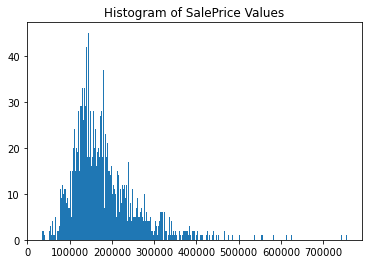

Dependent Variable Summary Statistics:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Dependent Variable Median: 163000.0
Dependent Variable Mean: 180921.0

Skew statistic : 1.880940746034036


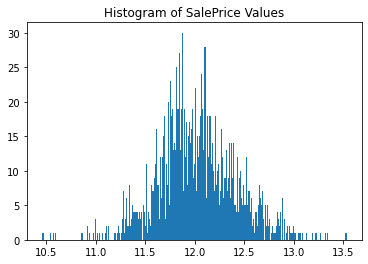

In [167]:
plt.hist(train['SalePrice'], bins = 300)
plt.title("Histogram of SalePrice Values")
plt.show()

print('Dependent Variable Summary Statistics:\n{0}\n'.format(train['SalePrice'].describe()))
print('Dependent Variable Median: {0}'.format(round(train['SalePrice'].median(), 0)))
print('Dependent Variable Mean: {0}\n'.format(round(train['SalePrice'].mean(), 0)))
print('Skew statistic : {0}'.format(skew(train['SalePrice'])))

plt.hist(np.log(train['SalePrice']), bins = 300)
plt.title("Histogram of SalePrice Values")
plt.show()

train['SalePrice'] = np.log(train['SalePrice'])

Check the distribution of the independent variables.

The dataset includes variables with a bell curve distribution, strong right skew, strong left skew, univerarite distribution, and variables whose values fall within a single bucket.

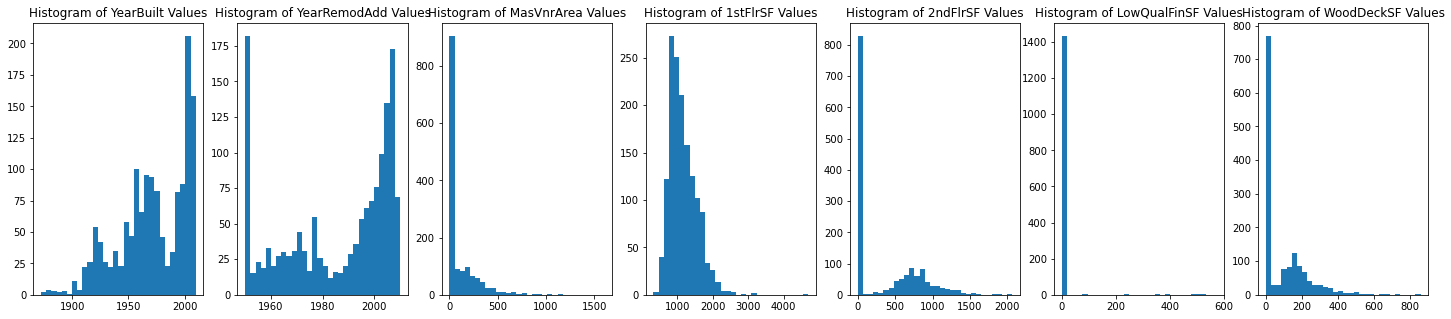

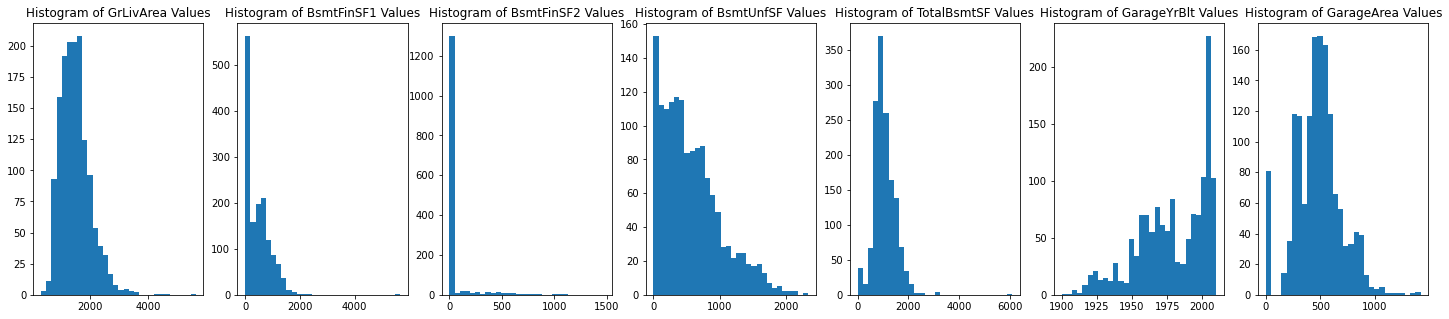

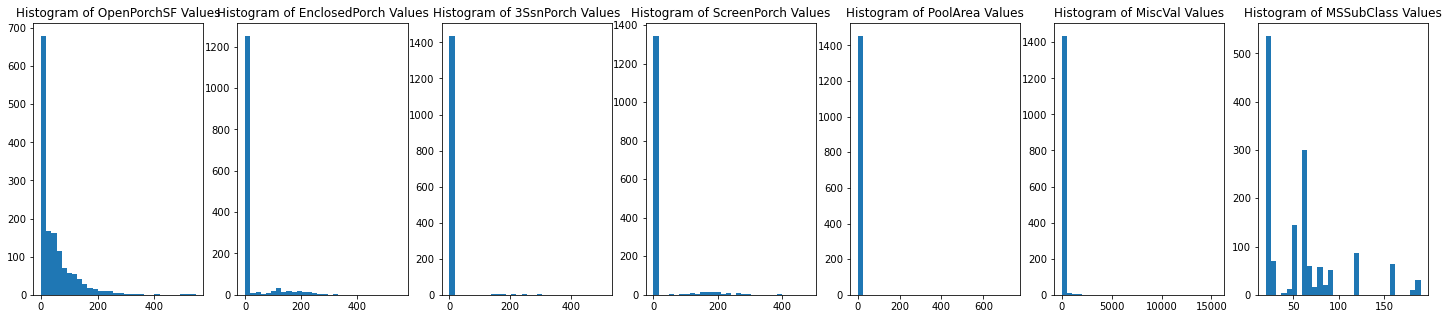

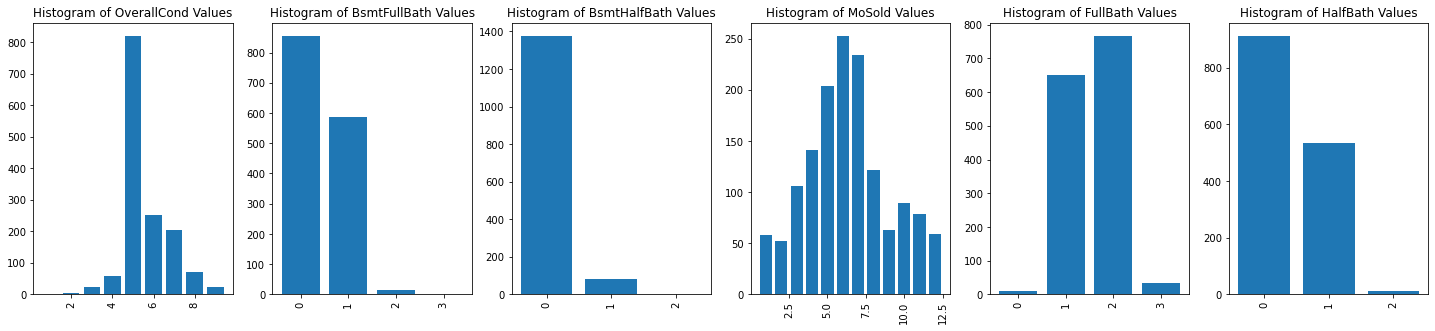

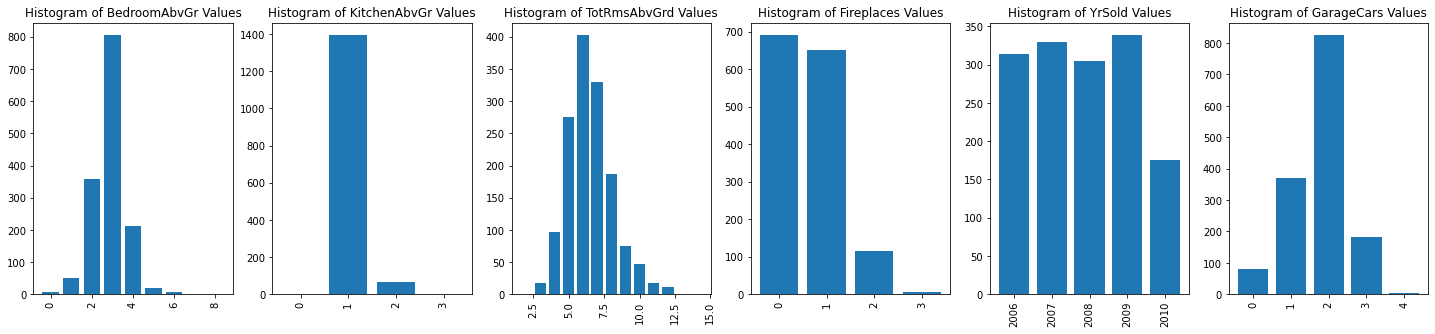

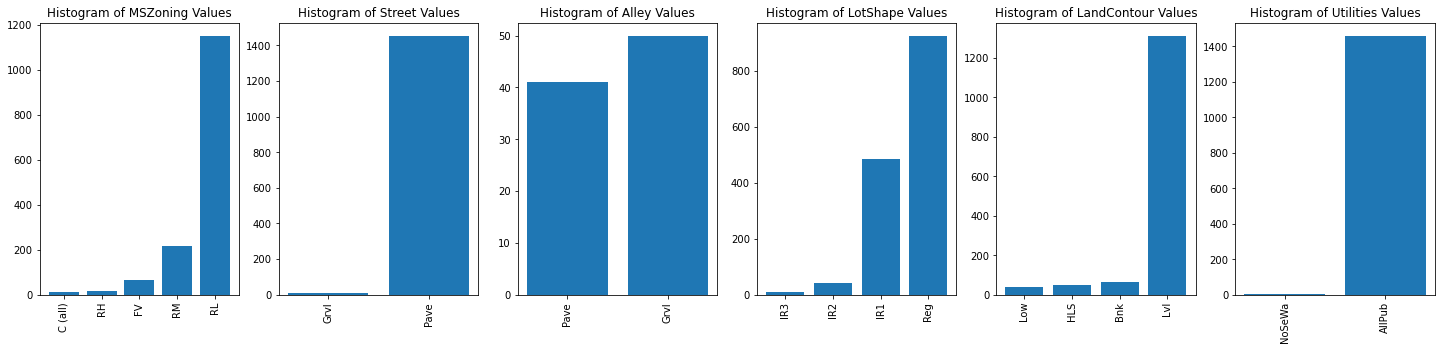

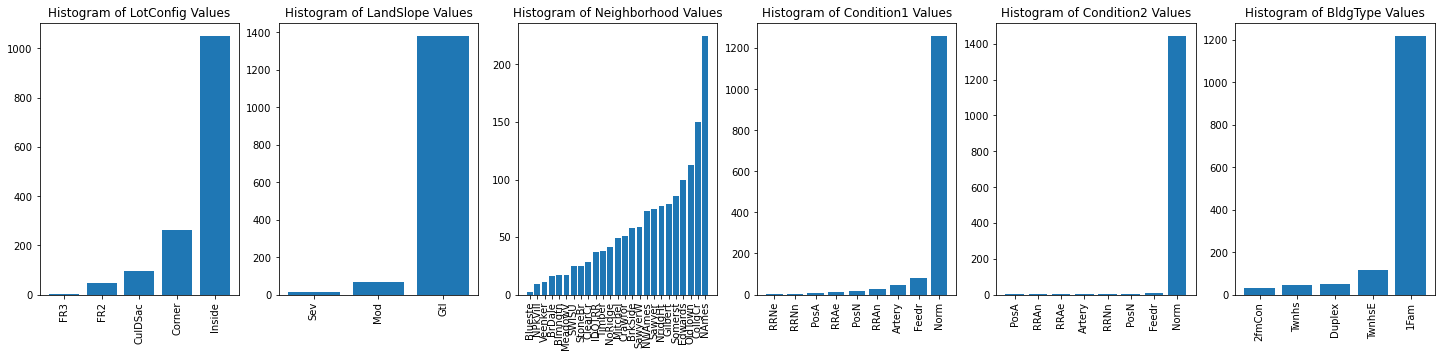

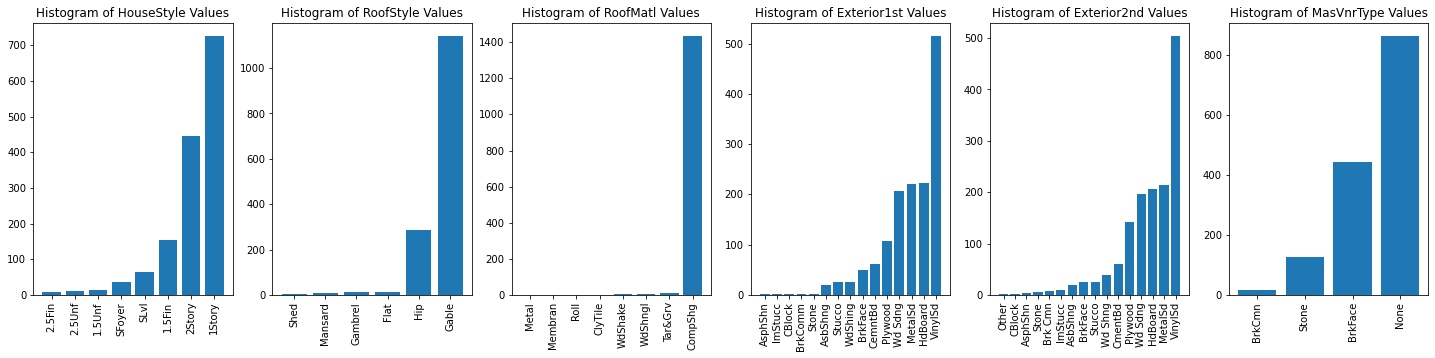

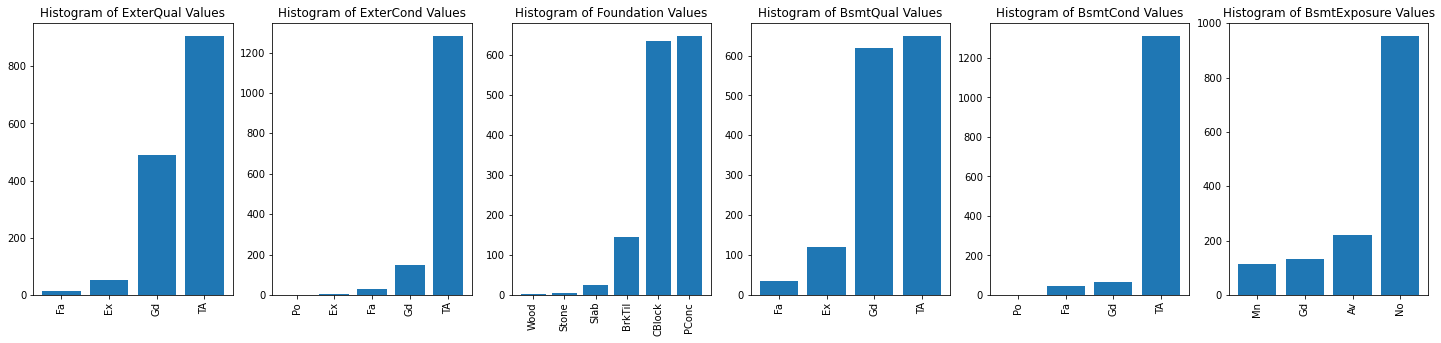

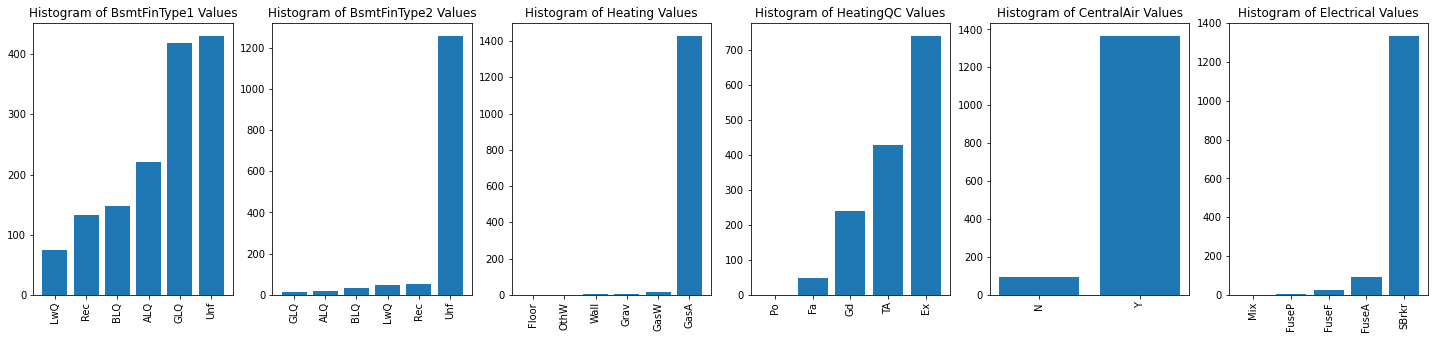

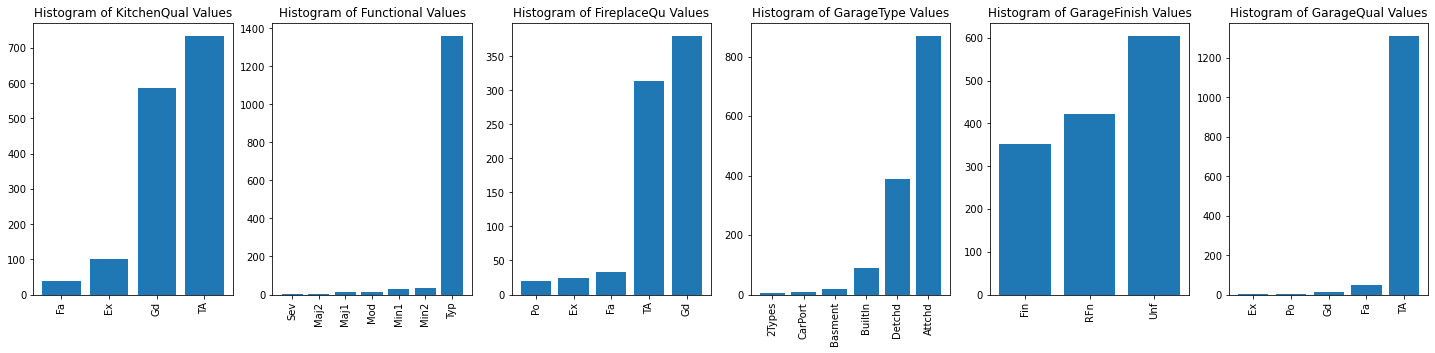

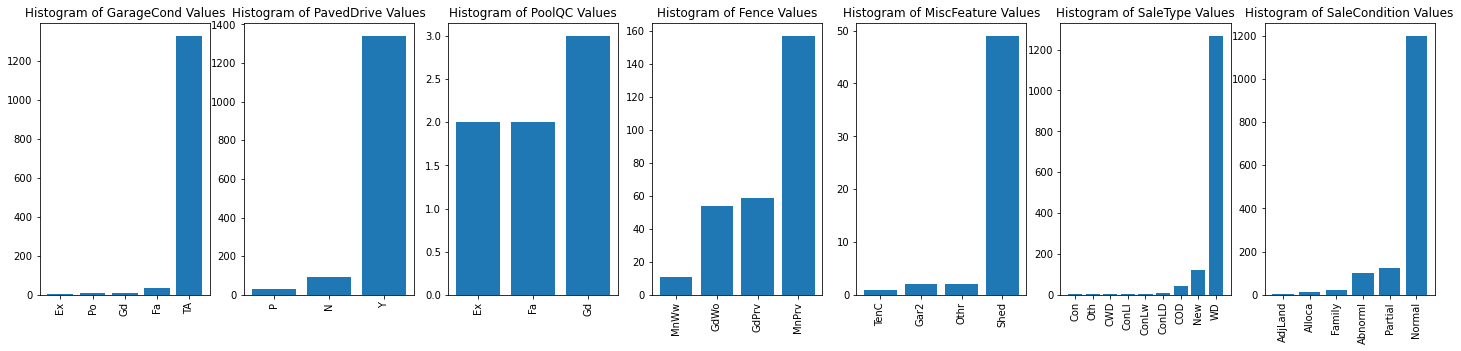

In [168]:
chart_gen('hist', 30, 7, train, ['YearBuilt', 'YearRemodAdd', 'MasVnrArea', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'WoodDeckSF'])
chart_gen('hist', 30, 7, train, ['GrLivArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageYrBlt', 'GarageArea'])
chart_gen('hist', 30, 7, train, ['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MSSubClass'])
chart_gen('bar', 0, 6, train, ['OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'MoSold', 'FullBath', 'HalfBath'])
chart_gen('bar', 0, 6, train, ['BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'YrSold', 'GarageCars'])
chart_gen('bar', 0, 6, train, ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities'])
chart_gen('bar', 0, 6, train, ['LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType'])
chart_gen('bar', 0, 6, train, ['HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType'])
chart_gen('bar', 0, 6, train, ['ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure'])
chart_gen('bar', 0, 6, train, ['BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical'])
chart_gen('bar', 0, 6, train, ['KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual'])
chart_gen('bar', 0, 7, train, ['GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'])

### Relationship between dependent variable and independent variables

Since our target feature to estimate is SalePrice, I visually examine the relationship between the dependent variable and independent variables by plotting a scatter plot with salePrice as the y axis and independent variables on the x axis.

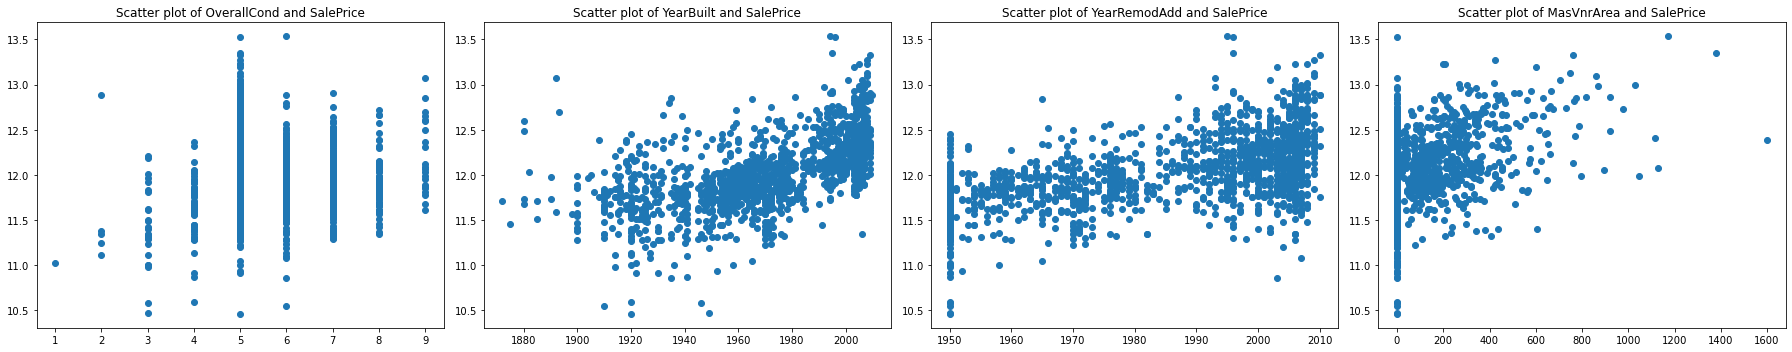

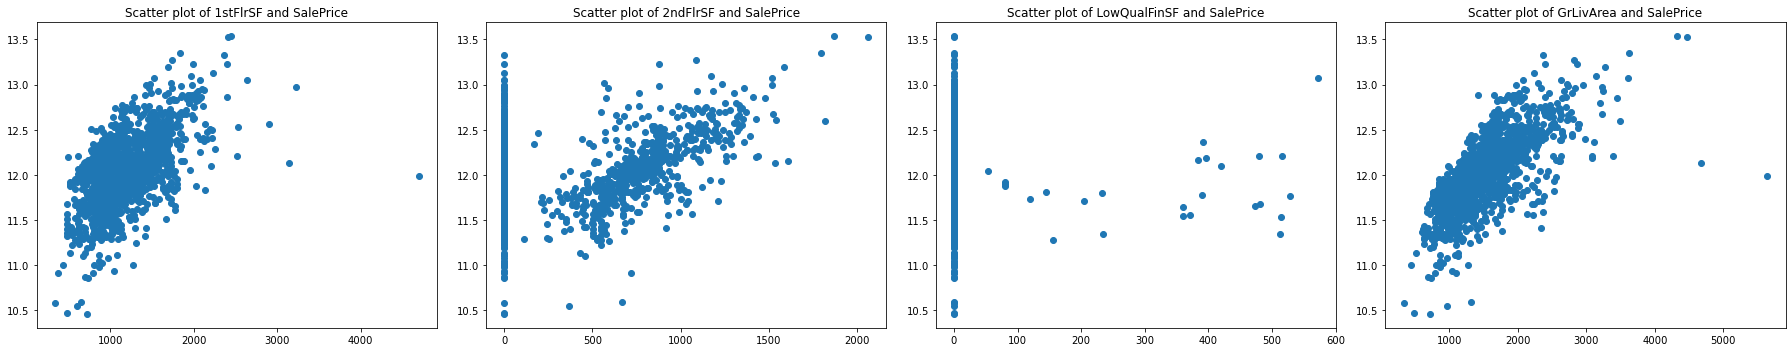

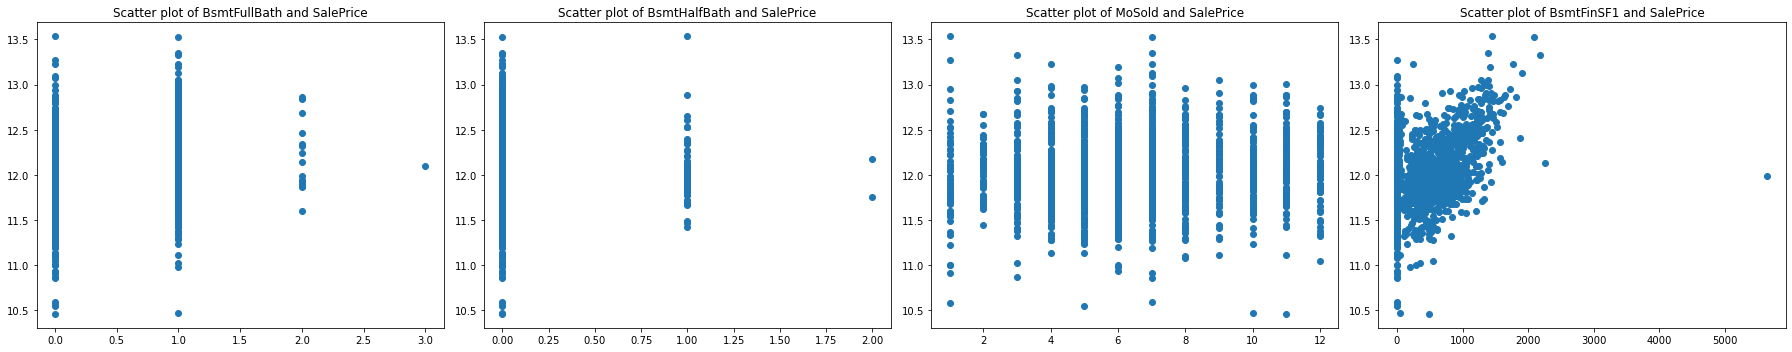

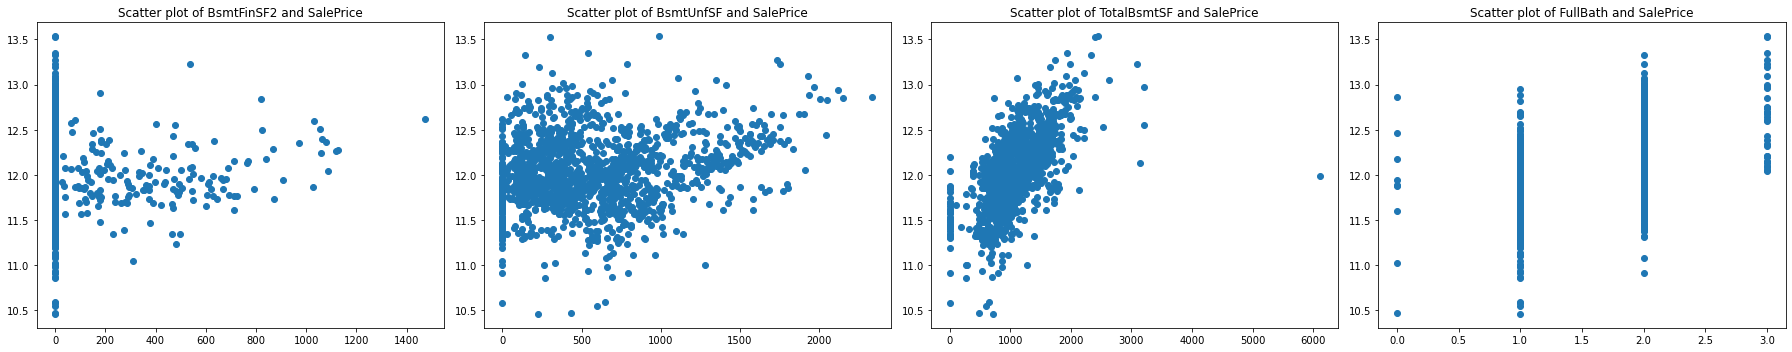

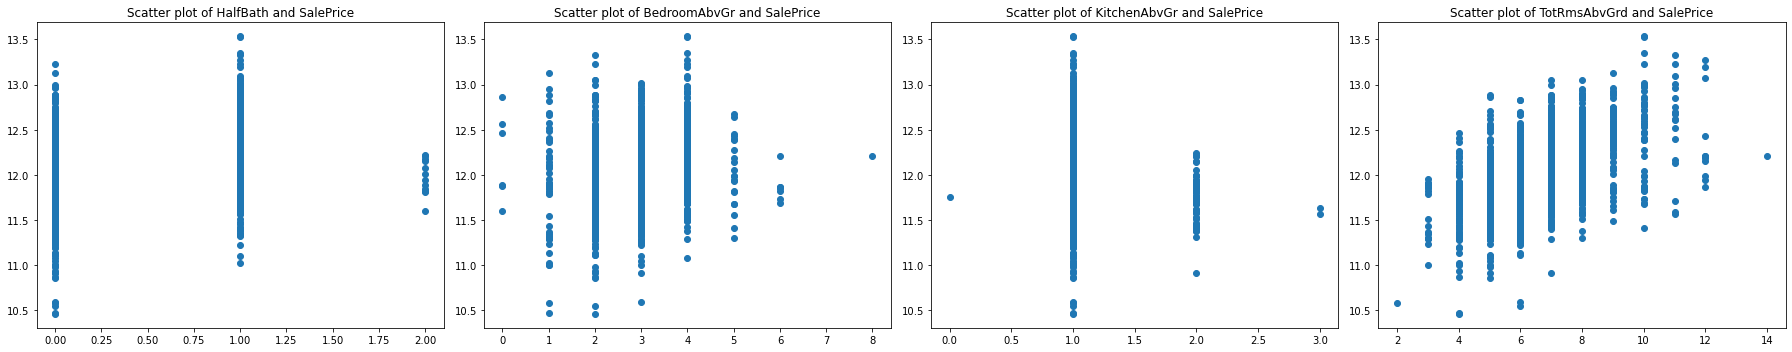

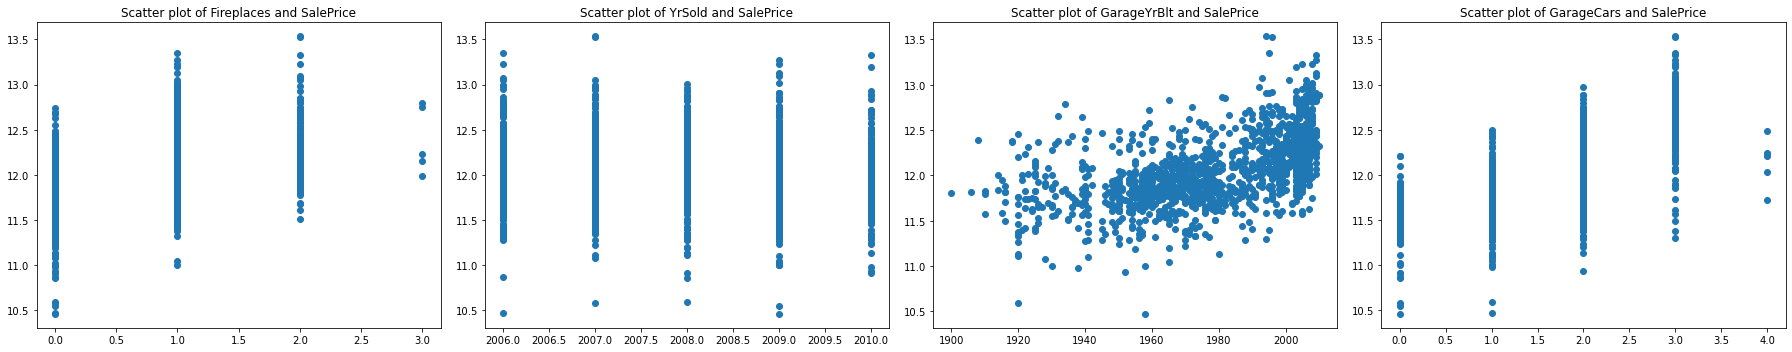

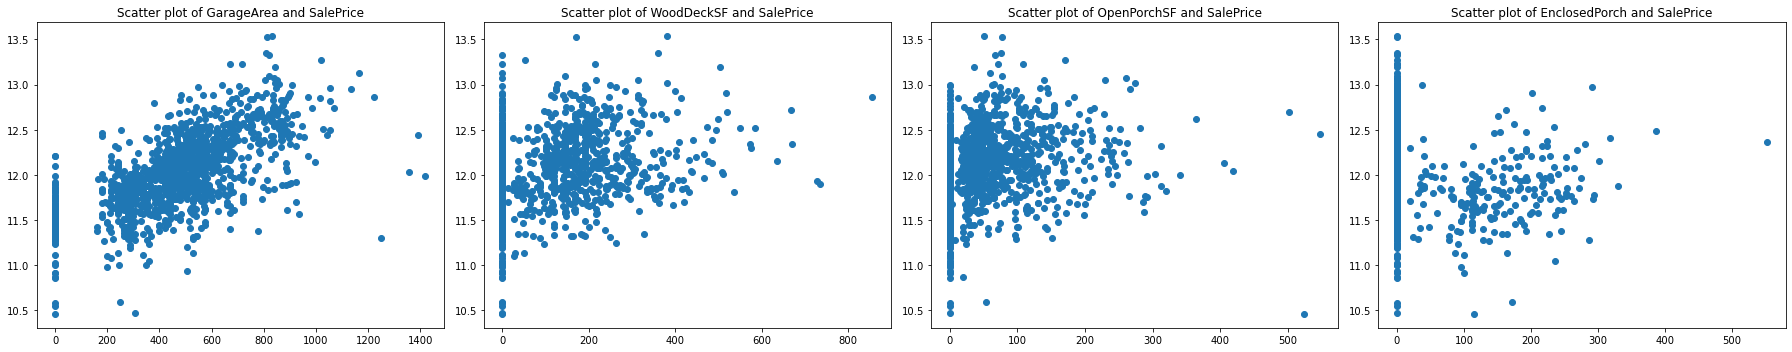

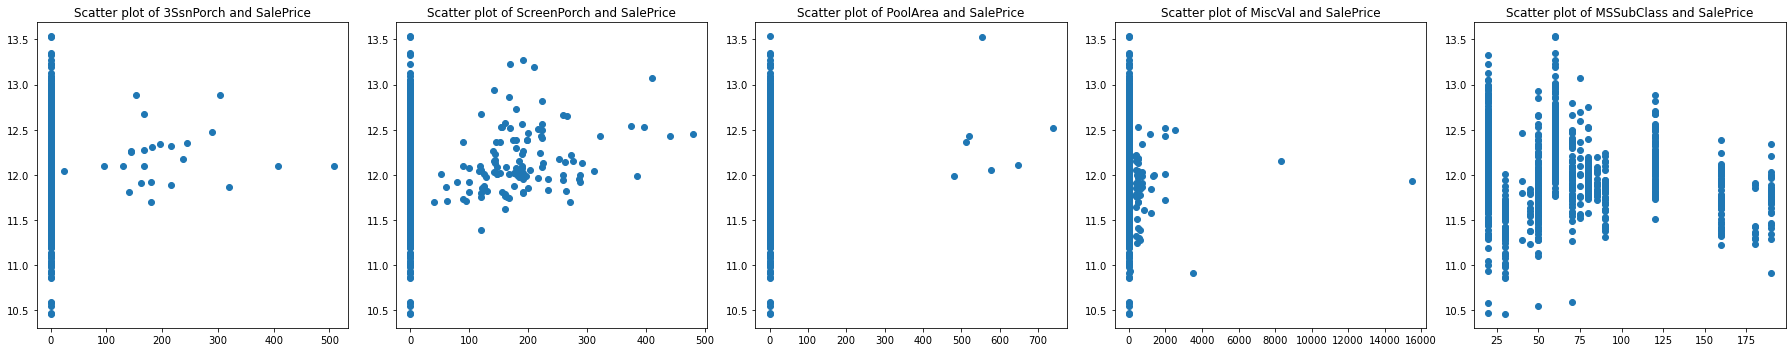

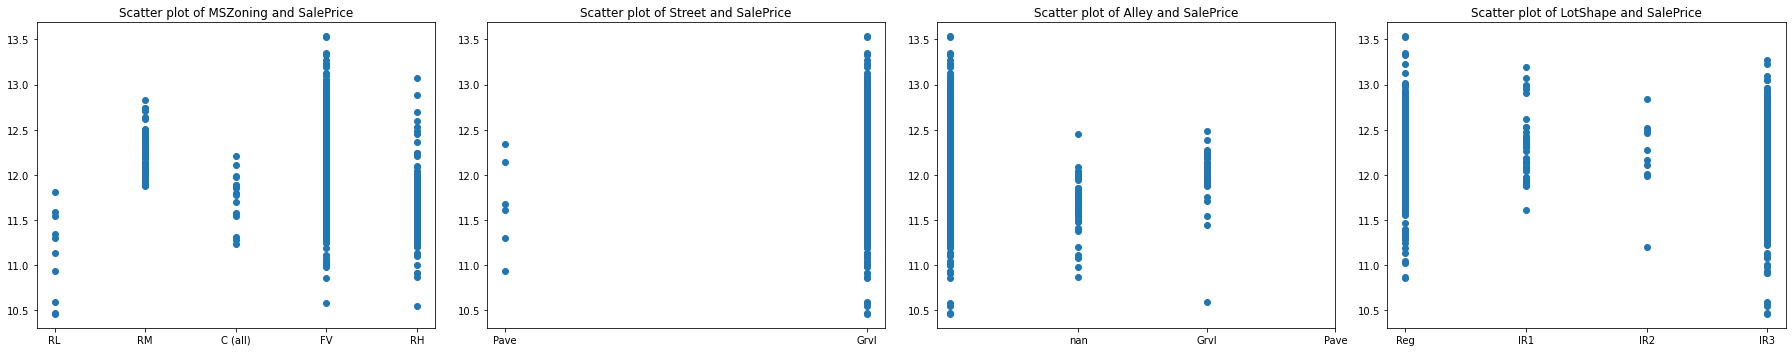

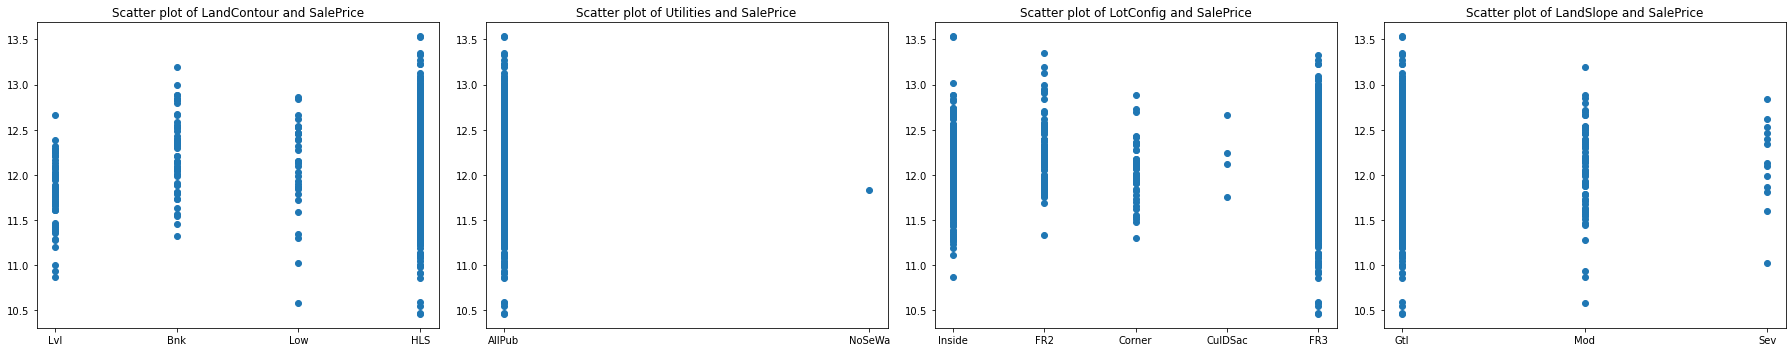

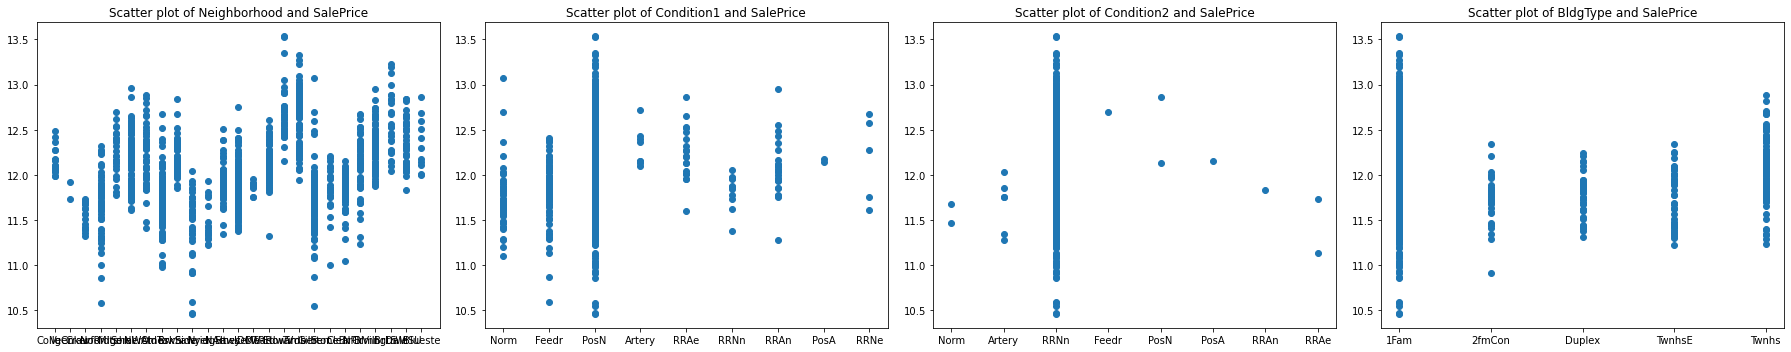

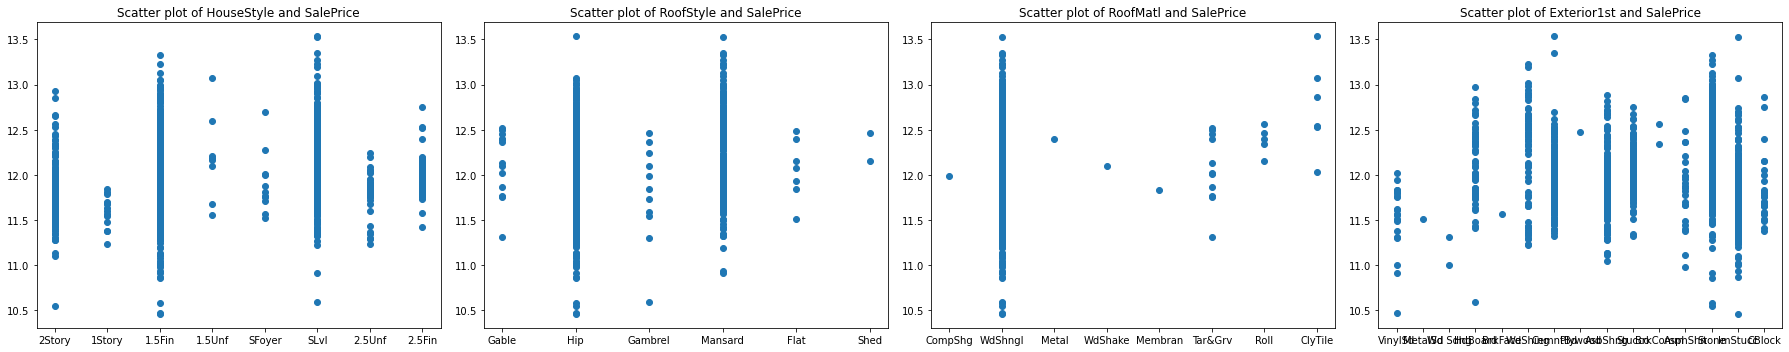

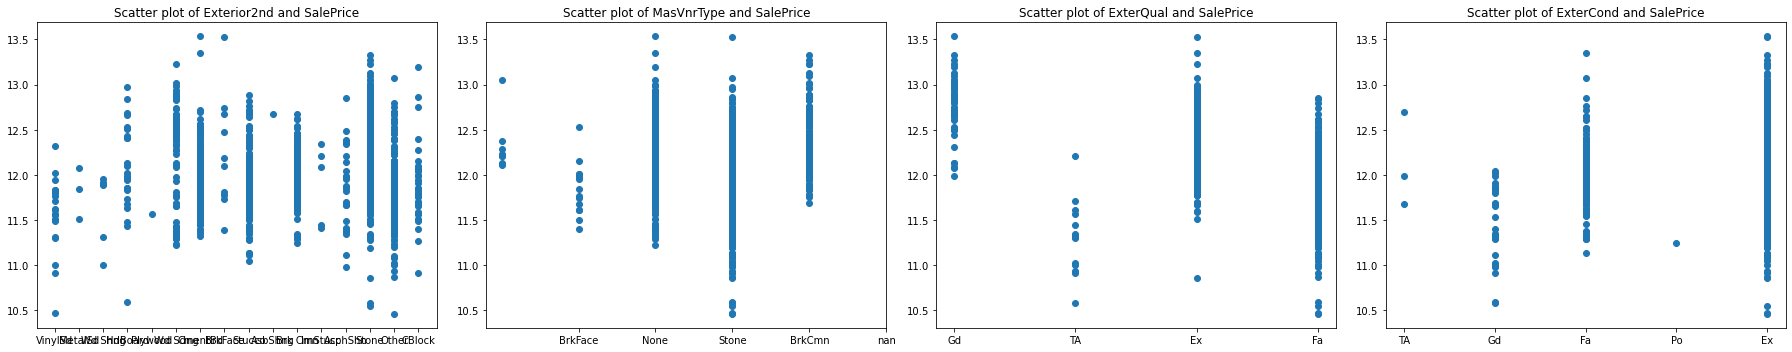

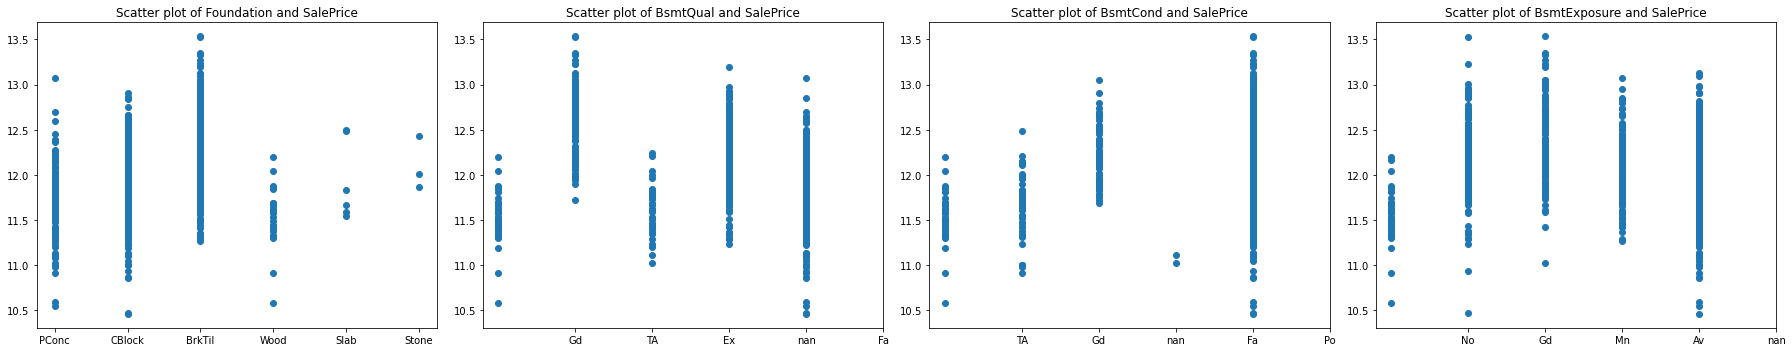

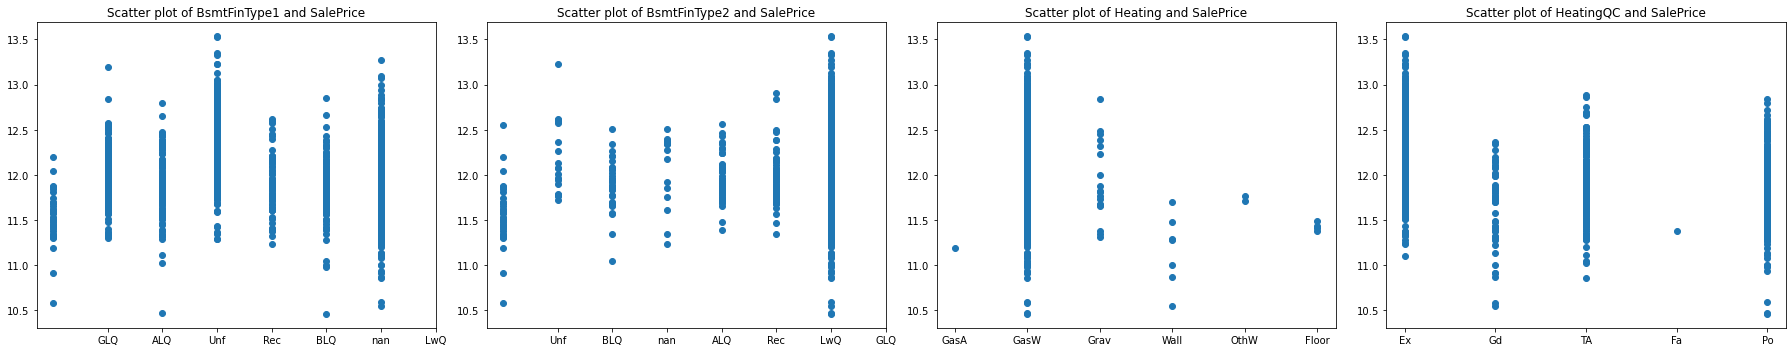

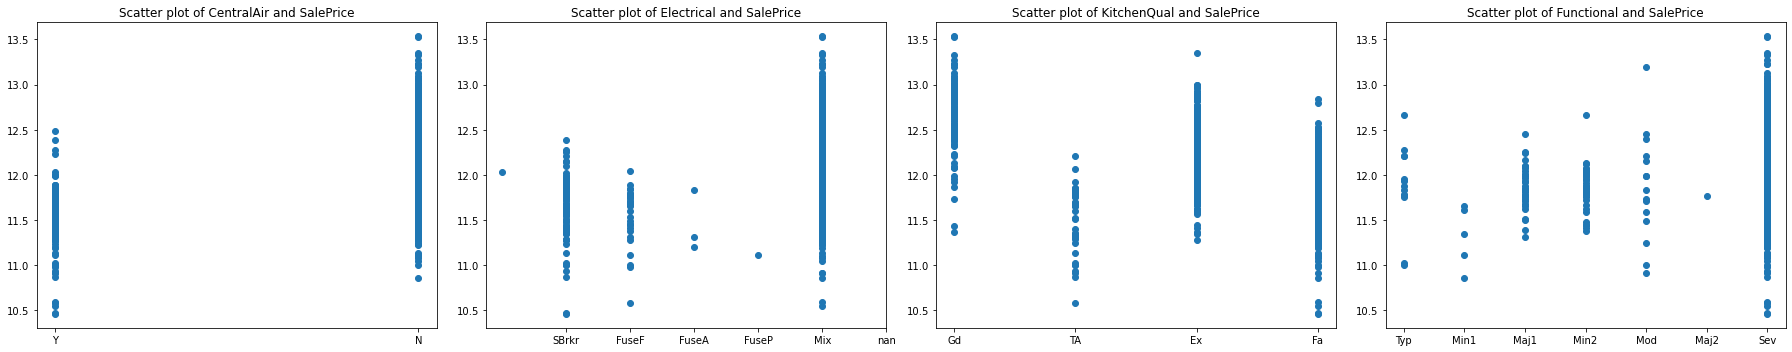

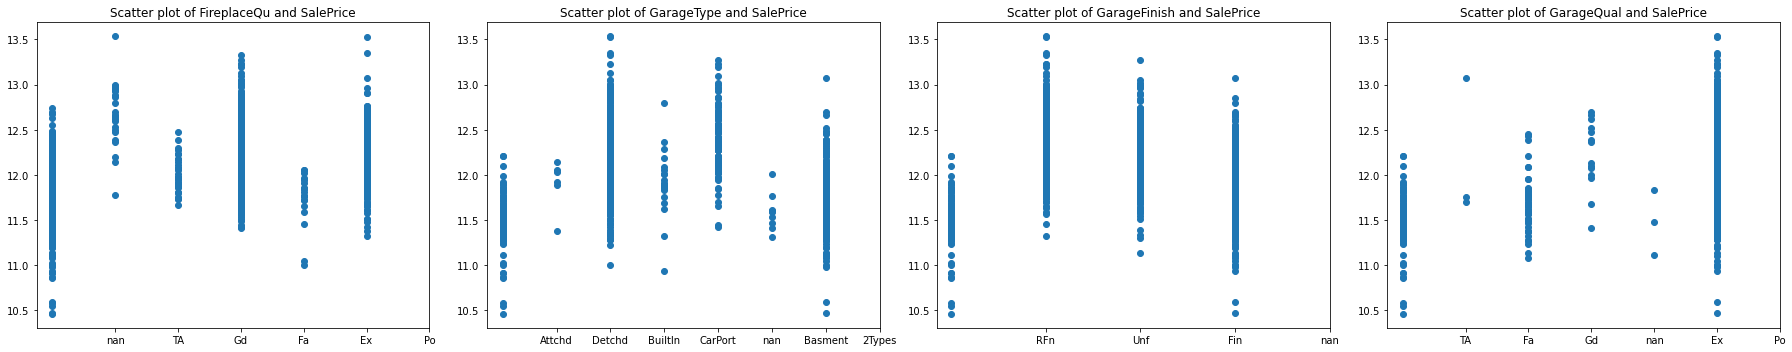

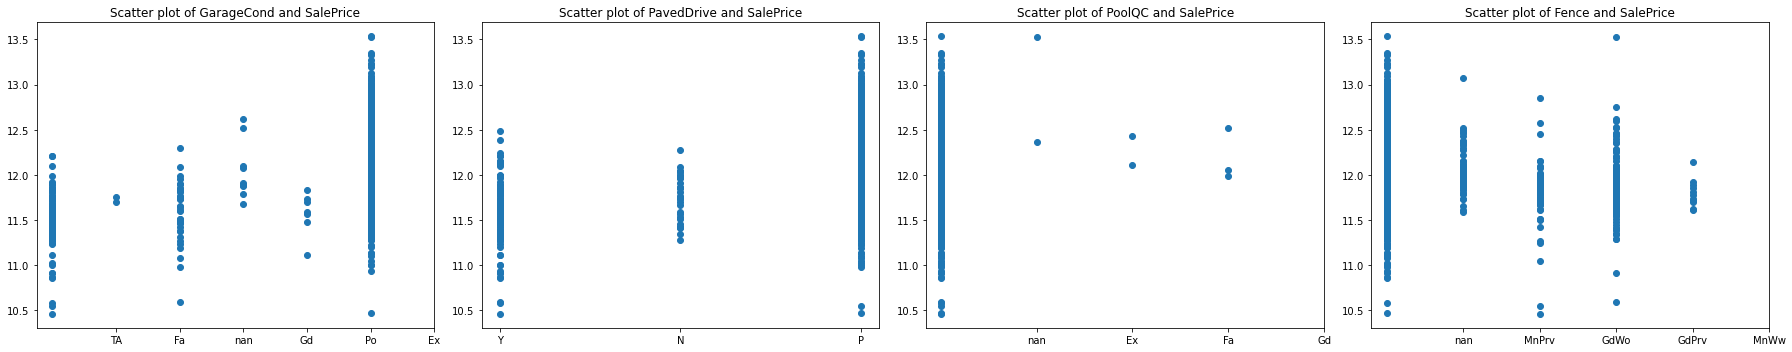

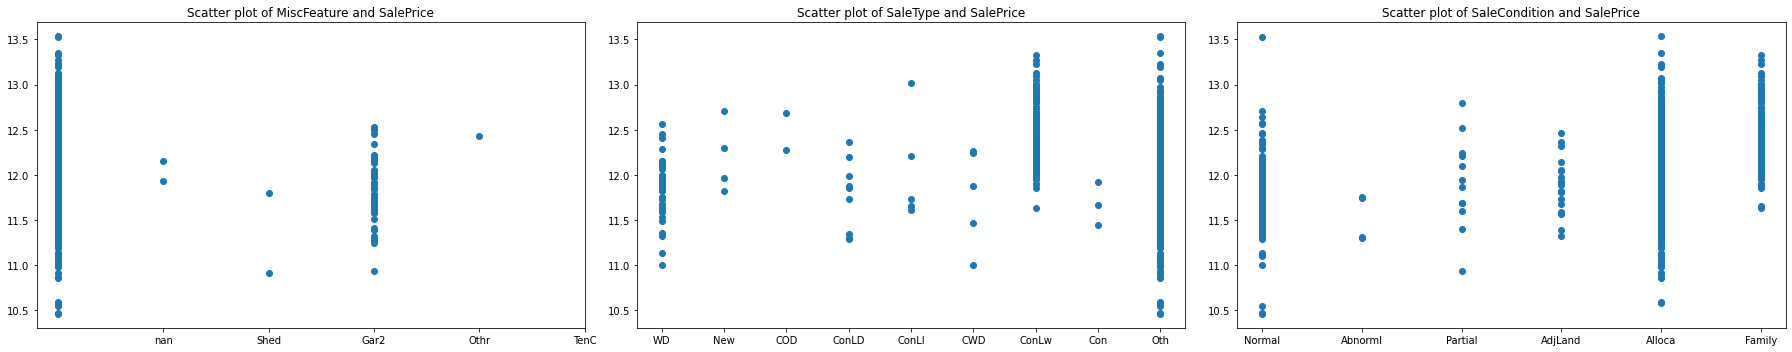

In [169]:
chart_gen('scatter', 0, 4, train, ['OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea'], 'SalePrice')
chart_gen('scatter', 0, 4, train, ['1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea'], 'SalePrice')
chart_gen('scatter', 0, 4, train, ['BsmtFullBath', 'BsmtHalfBath', 'MoSold', 'BsmtFinSF1'], 'SalePrice')
chart_gen('scatter', 0, 4, train, ['BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'FullBath'], 'SalePrice')
chart_gen('scatter', 0, 4, train, ['HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd'], 'SalePrice')
chart_gen('scatter', 0, 4, train, ['Fireplaces', 'YrSold', 'GarageYrBlt', 'GarageCars'], 'SalePrice')
chart_gen('scatter', 0, 4, train, ['GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch'], 'SalePrice')
chart_gen('scatter', 0, 5, train, ['3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MSSubClass'], 'SalePrice')
chart_gen('scatter-string', 0, 4, train, ['MSZoning', 'Street', 'Alley', 'LotShape'], 'SalePrice')
chart_gen('scatter-string', 0, 4, train, ['LandContour', 'Utilities', 'LotConfig', 'LandSlope'], 'SalePrice')
chart_gen('scatter-string', 0, 4, train, ['Neighborhood', 'Condition1', 'Condition2', 'BldgType'], 'SalePrice')
chart_gen('scatter-string', 0, 4, train, ['HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st'], 'SalePrice')
chart_gen('scatter-string', 0, 4, train, ['Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond'], 'SalePrice')
chart_gen('scatter-string', 0, 4, train, ['Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure'], 'SalePrice')
chart_gen('scatter-string', 0, 4, train, ['BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC'], 'SalePrice')
chart_gen('scatter-string', 0, 4, train, ['CentralAir', 'Electrical', 'KitchenQual', 'Functional'], 'SalePrice')
chart_gen('scatter-string', 0, 4, train, ['FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual'], 'SalePrice')
chart_gen('scatter-string', 0, 4, train, ['GarageCond', 'PavedDrive', 'PoolQC', 'Fence'], 'SalePrice')
chart_gen('scatter-string', 0, 3, train, ['MiscFeature', 'SaleType', 'SaleCondition'], 'SalePrice')

### Missing Values

I first determine which independent variables have missing values and on average, how many missing values does an observation have.

Three items jump out after the initial analysis. First, all observations are missing at  least 1 value with the vast majority (87%) missing 3-5 values. These 3-5 independent variables missing for an observation are likely to be Alley, FireplaceQu, PoolQC, Fence, and MiscFeature since they have the highest amount missing. 

Second, related variables appear to have a similar number of missing values. For example, the independent variables related to basements are missing values for 37 observations (and 36 in one of the features) and independent variables related to garages are all missing values for 81 observations.

Third, the NaN's may represent the feature not existing rather than actual missing data. Looking at the above distribution graphs, we can that for Alley, FireplaceQu, PoolQC, Fence, and MiscFeature, none of these variables have a "None" or "Not Applicable" value. This is a strong assumption but makes sense since not all houses have an alley, fireplace, pool, fence, or miscellaneous feature. We can verify this theory for at least PoolQC through the PoolArea variable that is not missing any data. 

Looking at the data_description.txt file, we do see the NA has been used to signify None for PoolQC, Fence, MiscFeature, and Alley. We will replace this value in the preprocessing stage to signify None.

Imputation or dropping observations/columns will occur under the preprocessing step.

In [170]:
# Determine how many NAN values each observation has
train['n_na'] = 0
for i in range(0, len(train)):
    train.loc[i, 'n_na'] = train.loc[i, :].isnull().sum()

print("Value Counts of the # of NaN's in an observation:")
print(train['n_na'].value_counts().sort_values(ascending=False))

Value Counts of the # of NaN's in an observation:
4     635
5     501
3     132
10     60
6      58
9      32
2      16
11      7
8       5
7       5
15      4
14      3
1       2
Name: n_na, dtype: int64


In [171]:
# Obtain the name of the column and number of missing values

missing_values = pd.DataFrame(columns = ['Column Name', '# NaN'])

for i in range(0, len(train.columns)):
    count = train.iloc[:, i].isnull().sum()
    if count > 0:
        new_row = {'Column Name': train.columns[i], '# NaN': count}
        missing_values = missing_values.append(new_row, ignore_index=True)

In [172]:
missing_values

Column Name # NaN
0    LotFrontage   259
1          Alley  1369
2     MasVnrType     8
3     MasVnrArea     8
4       BsmtQual    37
5       BsmtCond    37
6   BsmtExposure    38
7   BsmtFinType1    37
8   BsmtFinType2    38
9     Electrical     1
10   FireplaceQu   690
11    GarageType    81
12   GarageYrBlt    81
13  GarageFinish    81
14    GarageQual    81
15    GarageCond    81
16        PoolQC  1453
17         Fence  1179
18   MiscFeature  1406

<AxesSubplot:>

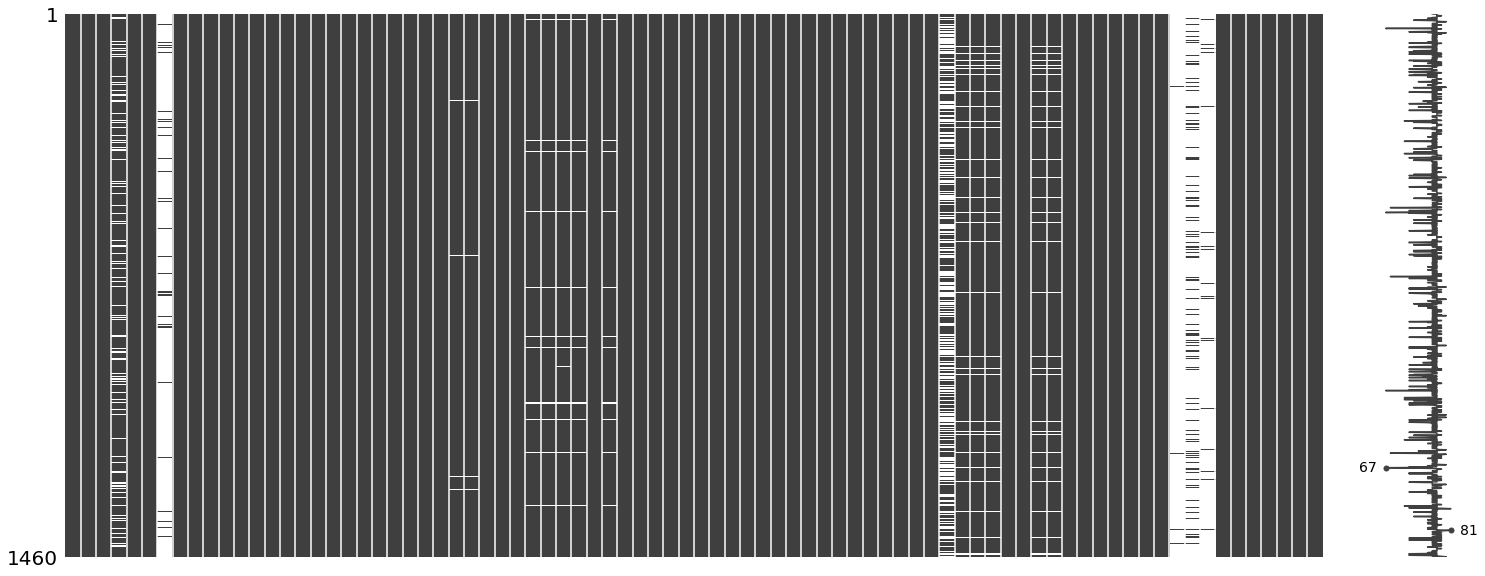

In [173]:
msno.matrix(train[train['SalePrice'].notnull()])

## Preprocessing 

Create a new training set to clean. Additionally drop the Id column

In [174]:
train_clean = copy.deepcopy(train)
train_clean.drop(columns = ['Id'], axis = 1, inplace = True)

### Dealing with missing data

#### Variables: Fence, MiscFeature, PoolQC, FireplaceQu, and Alley

I tackle Fence, MiscFeature, PoolQC, FireplaceQu, Alley in a grouping since these five consist of the most missing values by a wide margin and all their NaNs should be recoded as "None"

In [175]:
for i in ['Fence', 'MiscFeature', 'PoolQC', 'FireplaceQu', 'Alley']:
    train_clean[i] = train_clean[i].fillna('None')

#### Variables: GarageType, GarageYrBlt, GarageFinish, GarageQual, GarageCond

I tackle garage related variables in a single grouping. Looking at data_description.txt, all their NaNs should be recoded as "None" to represent the property not having a garage.

In [176]:
for i in ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']:
    train_clean[i] = train_clean[i].fillna('None')

#### Variables: BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2

I tackle basement related variables in a single grouping. Looking at data_description.txt, all their NaNs should be recoded as "None" to represent the property not having a basement.

However, for BsmtExposure, we have an extra missing value compared to the rest. If the observation has a valid value for BasmtCond, then we could assume that it is meant to be coded as "No Exposure" rather than "No Basement". For BsmtFinType2, we also have an extra missing value compared to the rest. If the BsmtFinSF2 is greater than 0, we will assume "Unfinished". If it is equal to zero, then we will assume "No Basement"

In [177]:
train_clean.loc[(pd.isna(train_clean['BsmtCond']) == True) & (pd.isna(train_clean['BsmtExposure']) == True), 'BsmtExposure'] = 'No Exposure'
train_clean.loc[(pd.isna(train_clean['BsmtCond']) == False) & (pd.isna(train_clean['BsmtExposure']) == True), 'BsmtExposure'] = 'None'

In [178]:
train_clean.loc[(train_clean['BsmtFinSF2'] > 0) & (pd.isna(train_clean['BsmtFinType2']) == True), 'BsmtFinType2'] = 'No Exposure'
train_clean.loc[(train_clean['BsmtFinSF2'] == 0) & (pd.isna(train_clean['BsmtFinType2']) == True), 'BsmtFinType2'] = 'None'

In [179]:
for i in ['BsmtQual', 'BsmtCond', 'BsmtFinType1']:
    train_clean[i] = train_clean[i].fillna('None')

#### Variable: LotFrontage

Since there are other Lot variables, such as LotArea, LotShape, and LotConfig, I drop LotFrontage. The assumption is that these three variables will share some of the same explanation to the dependent variable variance as LotFrontage. Additionally, with 259 missing values, the imputation would have low accuracy.


In [180]:
train_clean.drop(columns = ['LotFrontage'], axis = 1, inplace = True)

#### Variable: Electrical

There is only one missing observation so I insert the most common value, in this case SBrkr which is found in 91.2% of all homes in the dataset

In [181]:
train_clean['Electrical'].value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [182]:
train_clean.loc[pd.isna(train_clean['Electrical']) == True, 'Electrical'] = 'SBrkr'

#### Variables: MasVnrType and MasVnrArea

To impute the values for MasVnrType and MasVnrArea, I use the median value, which in this case is no masonary and thus 0 area.

In [183]:
print(train_clean['MasVnrType'].value_counts())
print(train_clean['MasVnrArea'].value_counts())

train_clean.loc[pd.isna(train_clean['MasVnrType']) == True, 'MasVnrType'] = 'None'
train_clean.loc[pd.isna(train_clean['MasVnrArea']) == True, 'MasVnrArea'] = 0.0

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64
0.0      861
180.0      8
72.0       8
108.0      8
120.0      7
        ... 
562.0      1
89.0       1
921.0      1
762.0      1
119.0      1
Name: MasVnrArea, Length: 327, dtype: int64


### Feature creation

We can create new independent variables from the 78 currently available to us to create variables that are more closely correlated with the dependent variable and can potentially explain variation that other independent variables haven't done yet. We tackle creating a better measure of squarefootage, bathrooms, and deck/porch area.

Currently there are four variables encompassing all of the bathroom information. I create a single feature that captures all the bathrooms in a house. Most home buyers think of 2.5 baths not 2 full baths and 1 half bath. We can see that the new single variable ("Baths") is .08 more correlated to SalePrice than the previous highest bathroom variable of the four. 

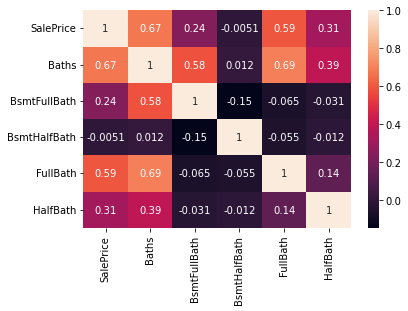

In [184]:
train_clean['Baths'] = train_clean['BsmtFullBath'] + train_clean['BsmtHalfBath']*.5 + train_clean['FullBath'] + train_clean['HalfBath']*.5

sn.heatmap(train_clean[['SalePrice', 'Baths', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath']].corr(), annot=True)
plt.show()

Currently there are three variables encompassing all of the square footage information. I create a single feature that captures all the square footage in a house plus garage. Most buyers look at aggregate square footage, not the individual square footage of the basement verus the area above grade (i.e. first floor and second floor). We can see that the new single variable ("TotSF") is .1 more correlated to SalePrice than the previous highest square footage variable of the three.

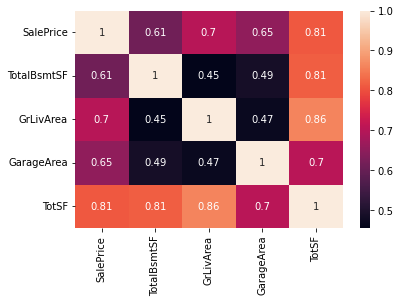

In [185]:
train_clean['TotSF'] = train_clean['TotalBsmtSF'] + train_clean['GrLivArea'] + train_clean['GarageArea']

sn.heatmap(train_clean[['SalePrice', 'TotalBsmtSF', 'GrLivArea', 'GarageArea', 'TotSF']].corr(), annot=True)
plt.show()

Currently there are six variables encompassing all of the square footage information for outdoor porches and decks. I create a single feature that captures all the square footage for decks/porches. Most buyers look at aggregate square footage, not the individual square footage. We can see that the new single variable ("OutdoorSF") is .07 more correlated to SalePrice than the previous highest square footage variable of the six.

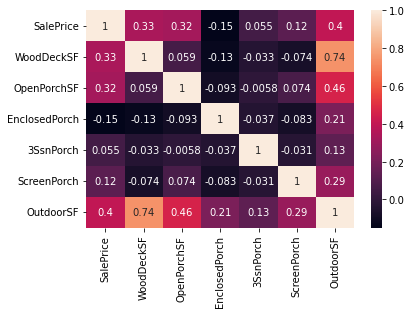

In [186]:
train_clean['OutdoorSF'] = train_clean['WoodDeckSF'] + train_clean['OpenPorchSF'] + train_clean['EnclosedPorch'] + train_clean['3SsnPorch'] + train_clean['ScreenPorch']

sn.heatmap(train_clean[['SalePrice', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'OutdoorSF']].corr(), annot=True)
plt.show()

### Categorical data

The dataset has X independent variables that are categorical. We handle these by creating dummy variables (1/0) for each potential value a indepdent variable could take on. We will later ensure we leave one option out to avoid collinearity. This means the interpretation of the coefficients of these dummy variables is the difference from the left-out option. 

In [187]:
cat_vars = ['BsmtFullBath', 'BsmtHalfBath', 'MoSold', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'YrSold',
            'GarageCars', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Neighborhood',
            'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 
            'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
            'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 
            'MiscFeature', 'SaleType', 'SaleCondition', 'GarageYrBlt']

In [188]:
y_train_clean = train_clean[['SalePrice']]

In [189]:
X_train_clean = train_clean.drop(['SalePrice'], axis = 1)

In [190]:
X_train_encoded = pd.get_dummies(data = X_train_clean, columns = cat_vars)

### Correlation heat map

I generate a large correlation mapping to see which variables seem to be likely predictors of SalePrice while keeping an eye on collinearity. 

Examining the heatmap results showing correlations between our independent variables and dependent variable (SalePrice), only a couple variables jump out as strong predictors of price (in either direction). OverallQual, YearBuilt, YearRemodAdd, TotSF, and Baths. All of these have a correlation of absolute value of .5 or higher. 

We see some interesting results when we look at the dummy variables that were generated from categorical variabes. We see that having a single full bath above grade is penalized while having two or more full baths is rewarded. We additionally see this starkly with the # of cars in a garage. 1 space is penalized, 2 spaces is assumed (correlation is almost 0) and 3 spaces has a correlation of .61. Looking at Fireplaces, housing styles, roof stle, exterior, central air, heating, kitchen qualit, garaget type, garage finish, sale type, and garage year built we see similar patterns where having a certain type of feature is rewarded, others are penalized, and some types have no impact on price. 

#### Heat map results

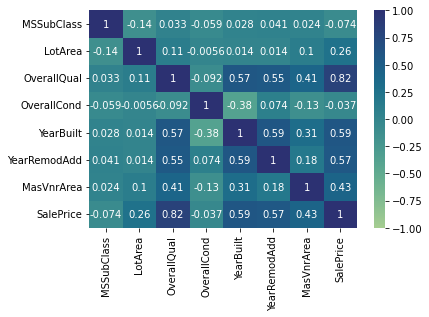

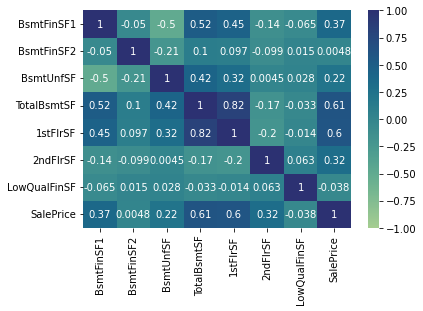

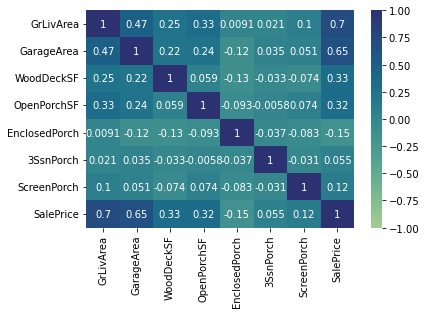

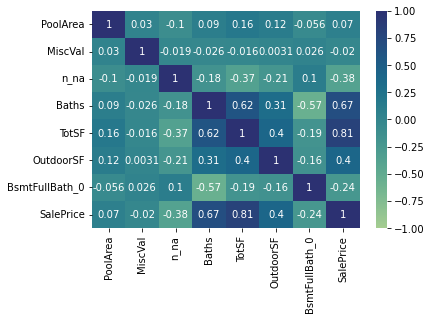

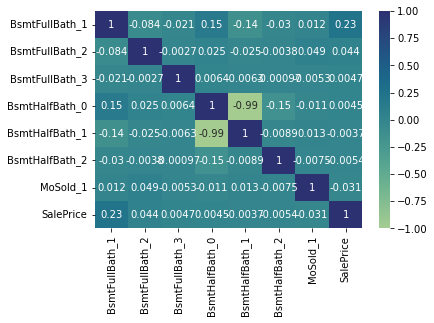

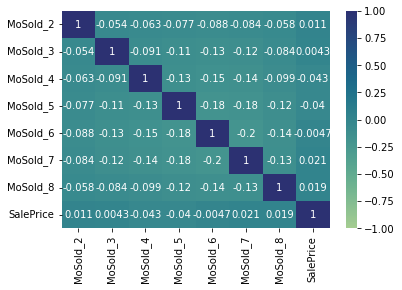

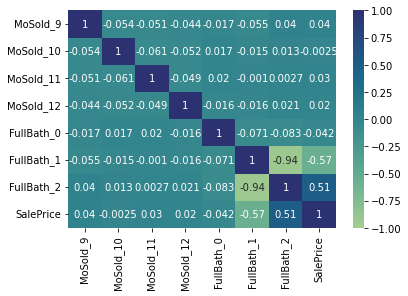

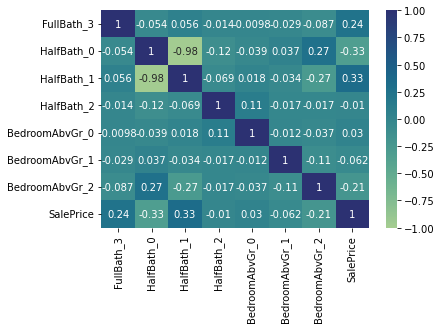

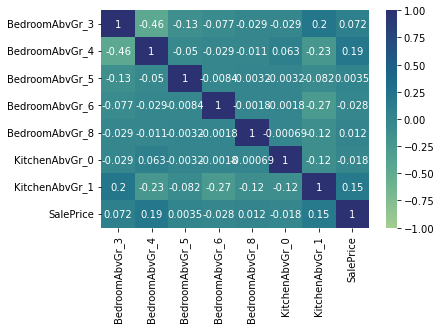

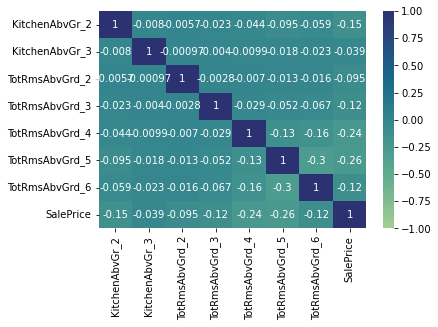

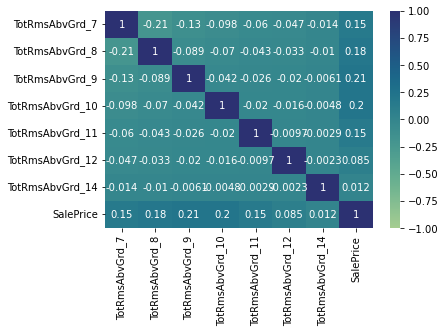

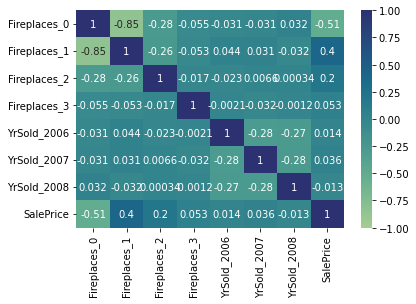

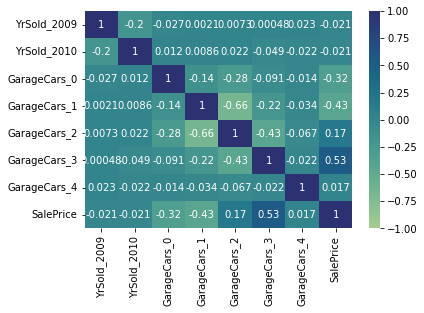

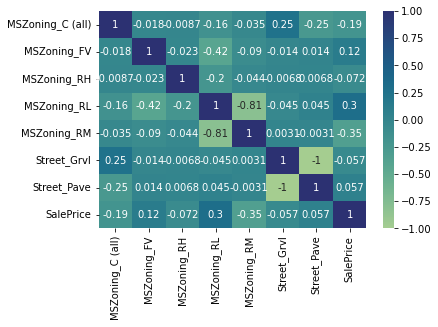

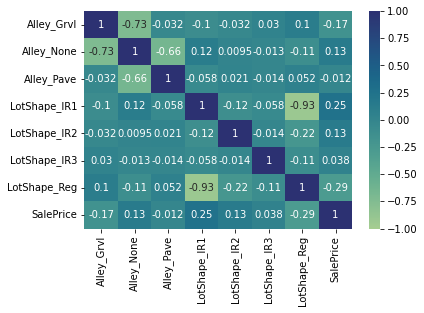

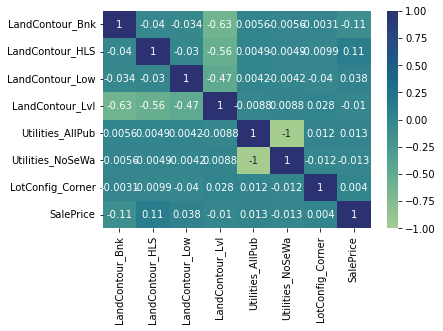

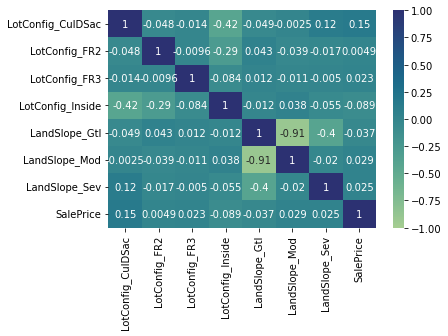

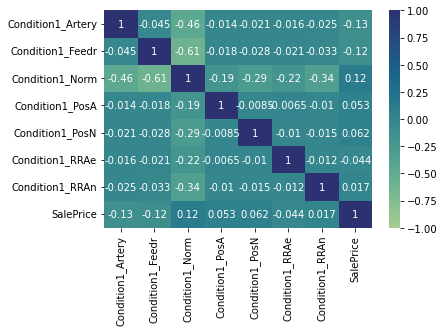

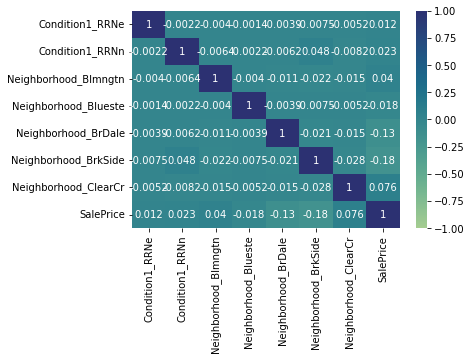

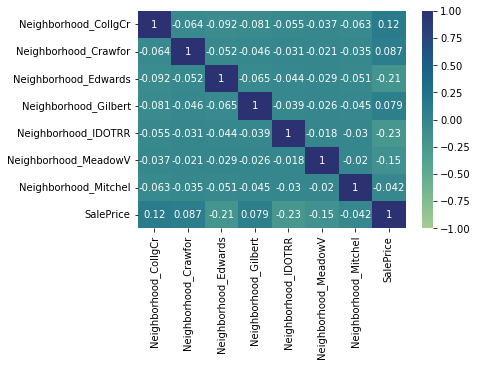

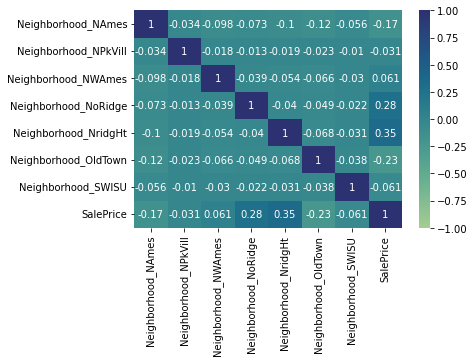

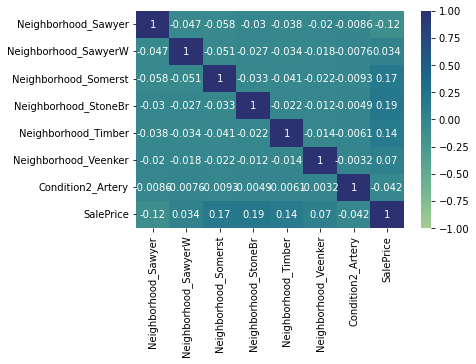

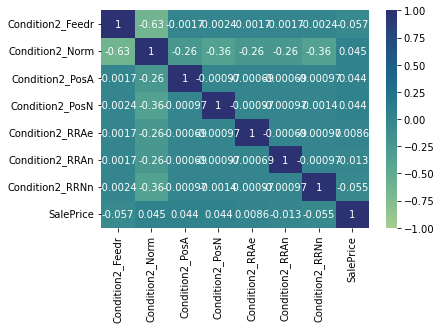

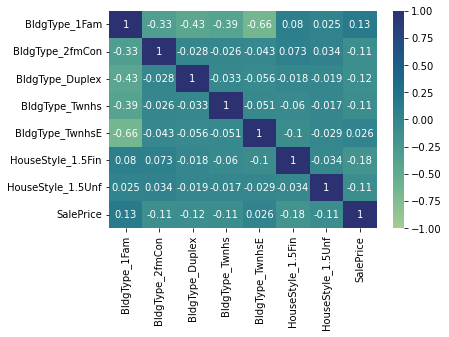

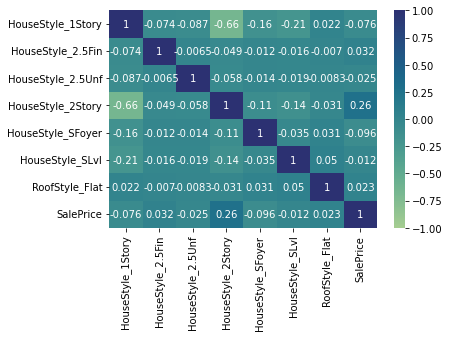

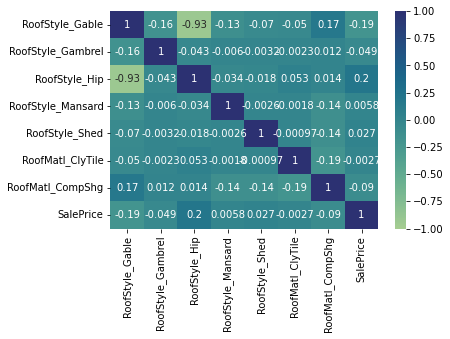

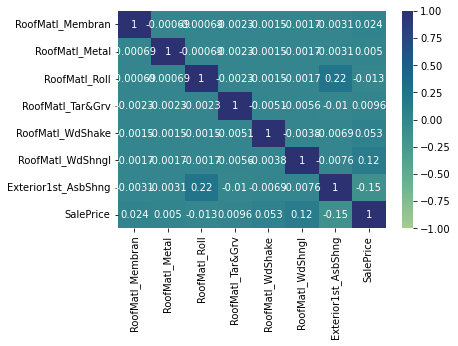

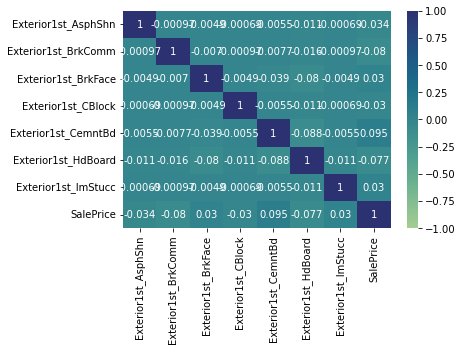

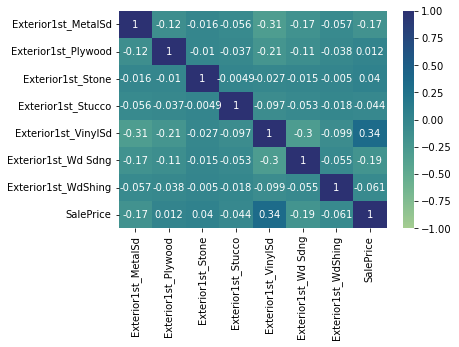

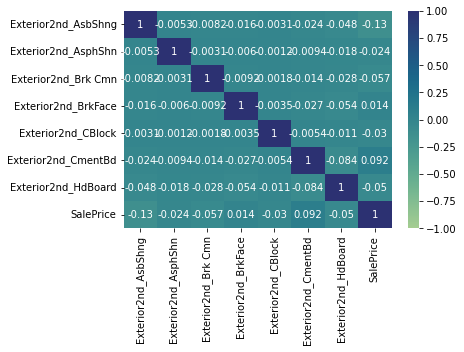

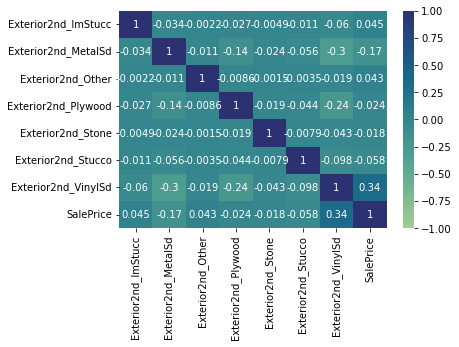

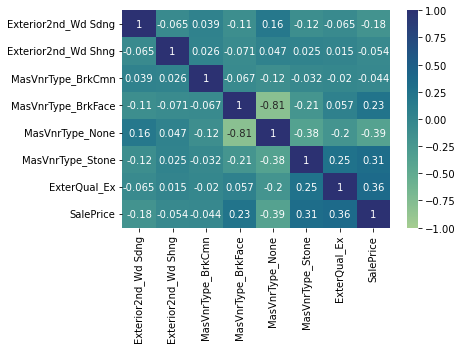

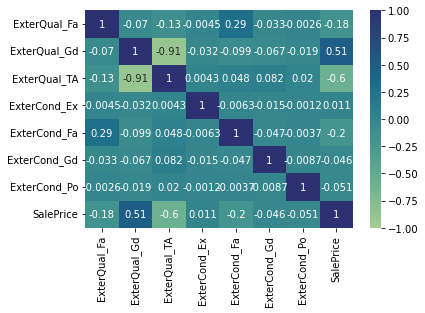

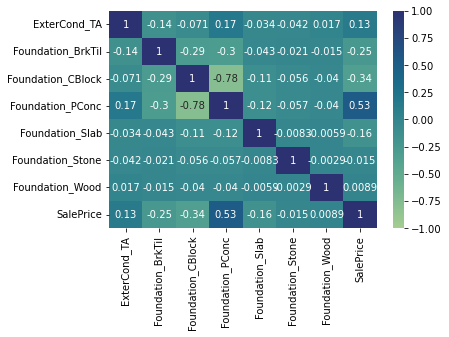

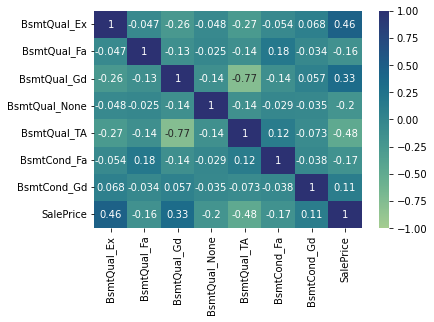

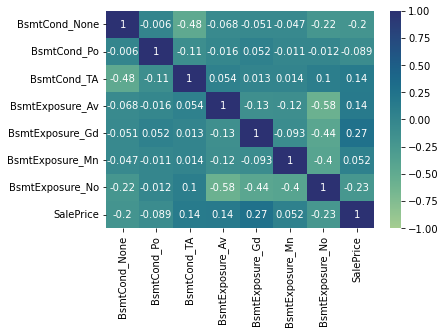

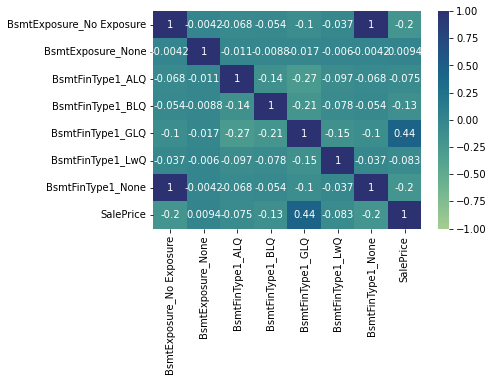

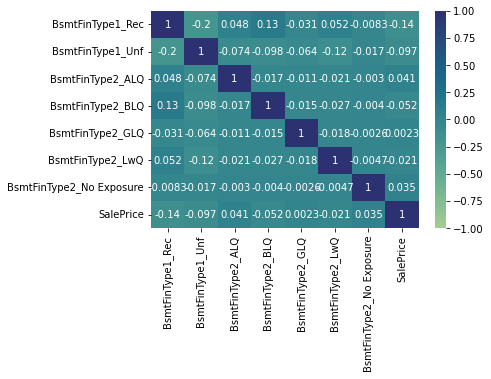

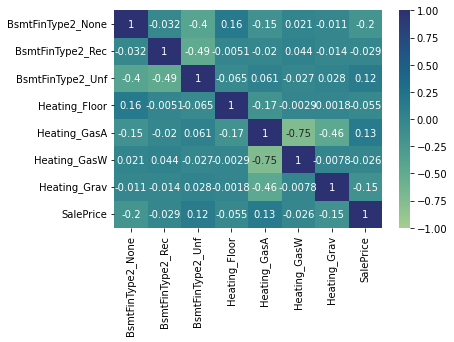

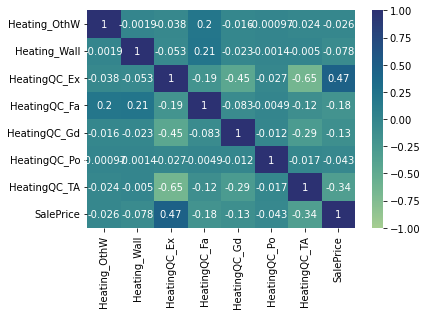

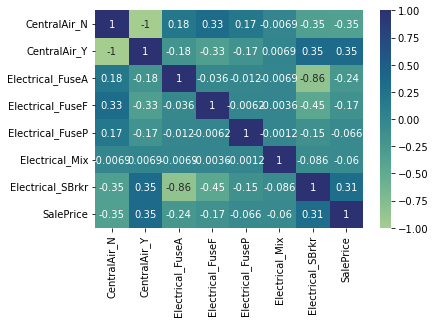

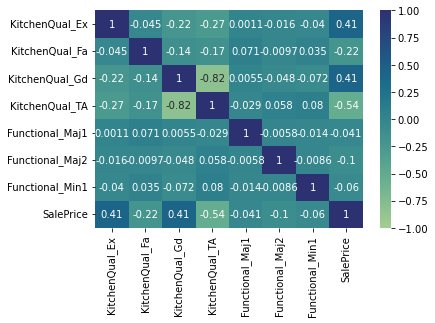

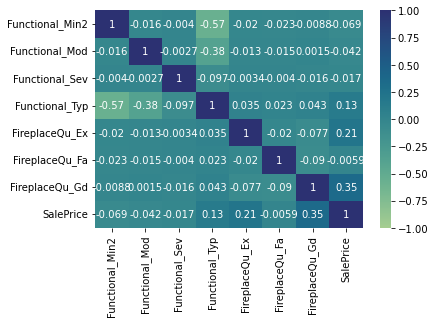

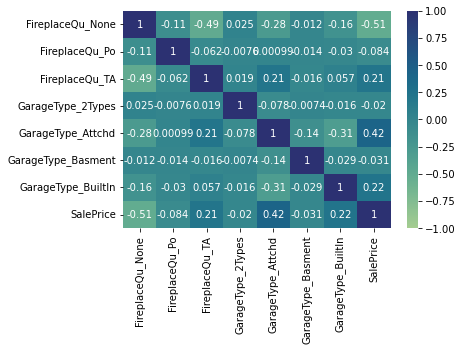

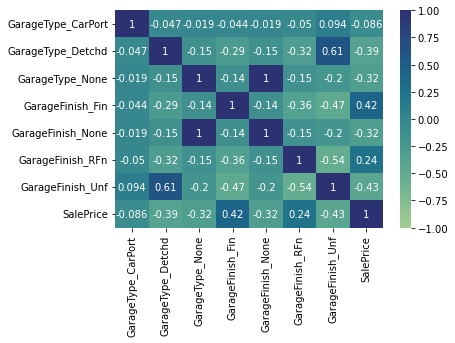

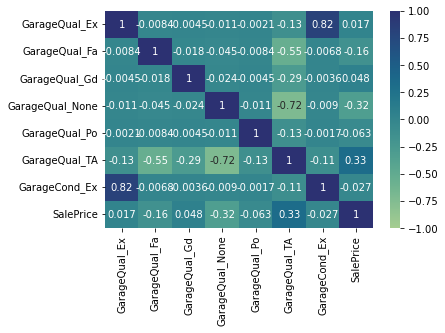

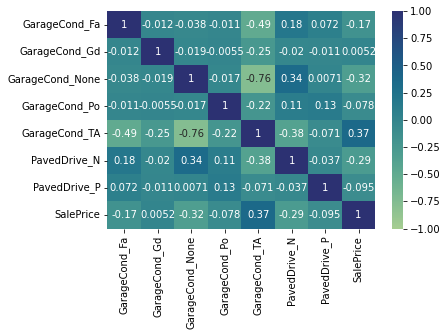

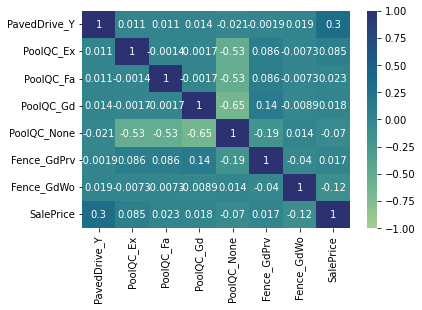

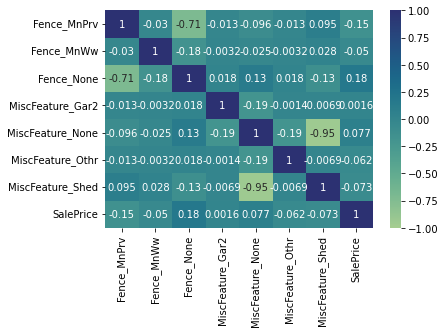

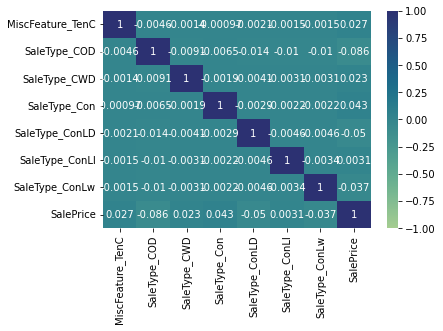

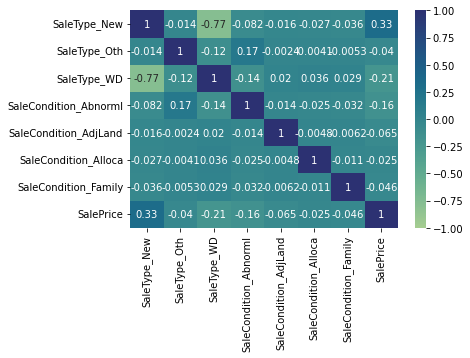

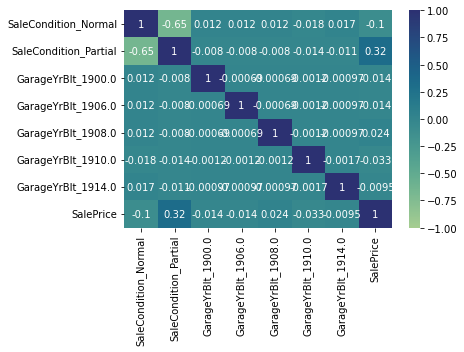

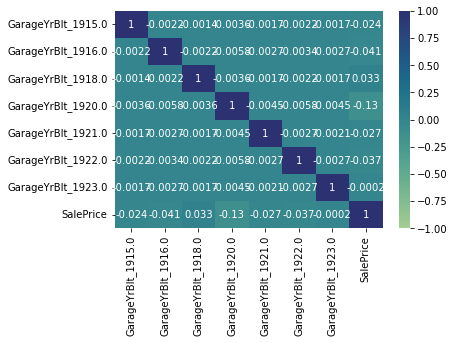

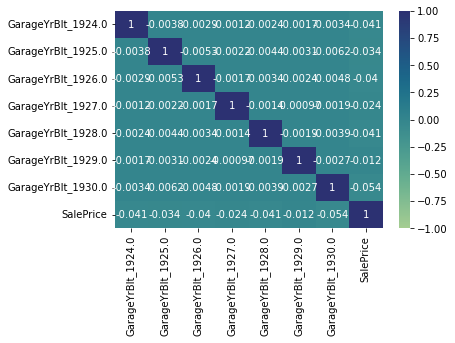

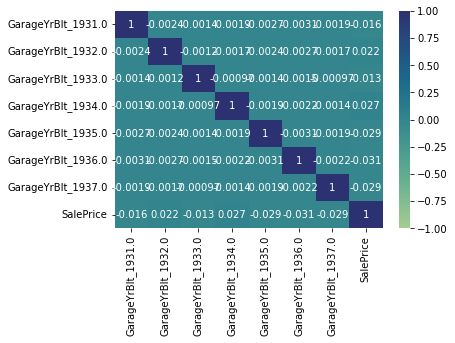

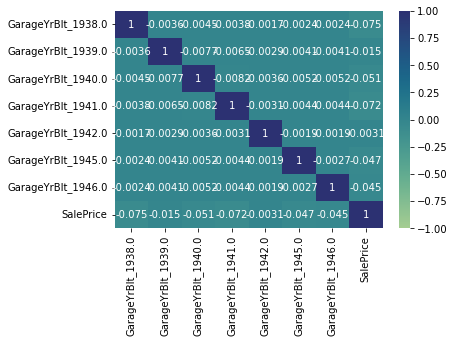

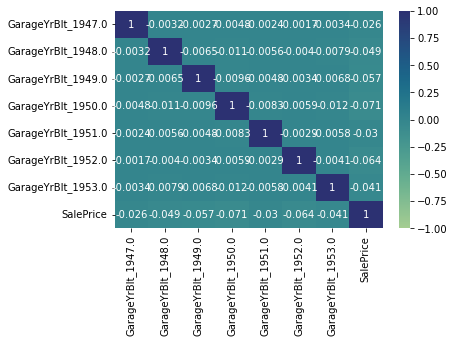

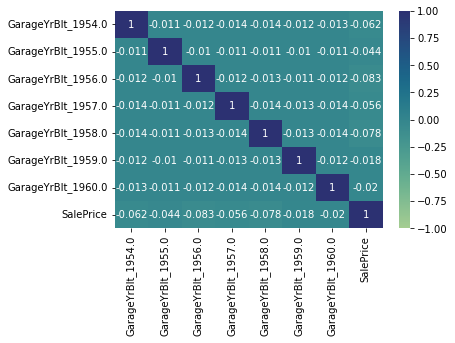

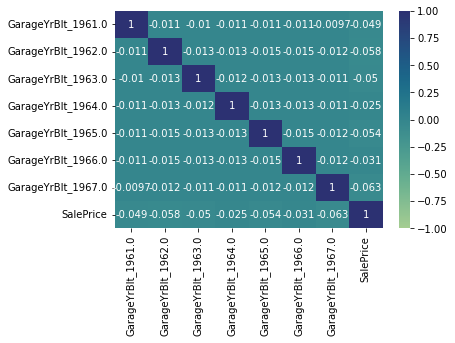

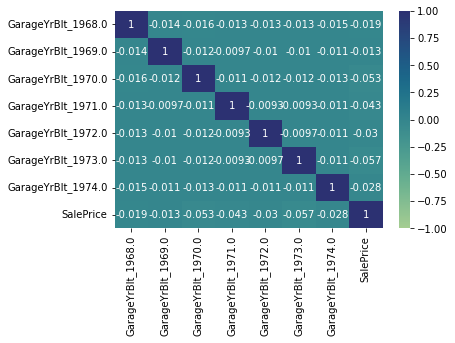

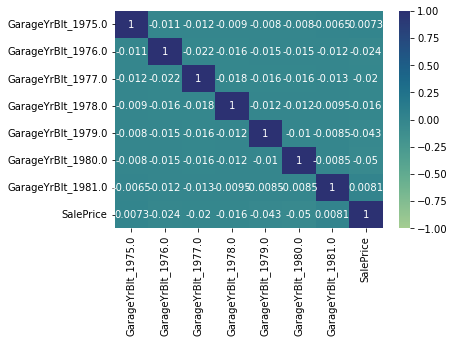

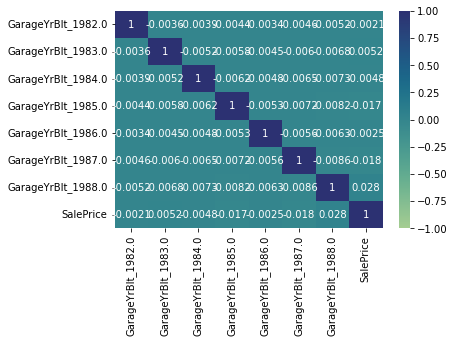

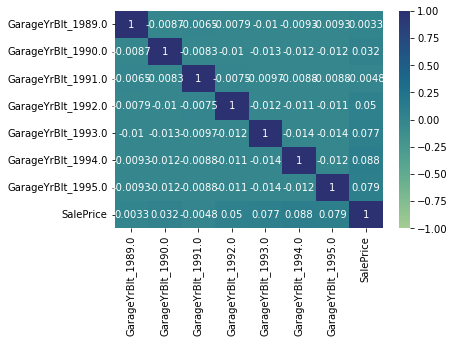

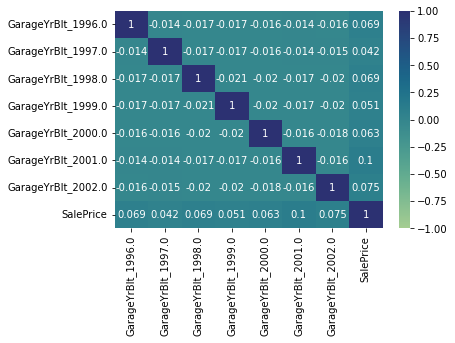

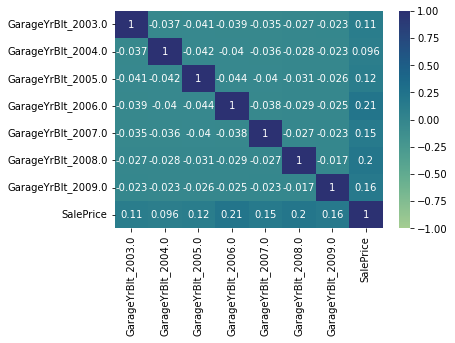

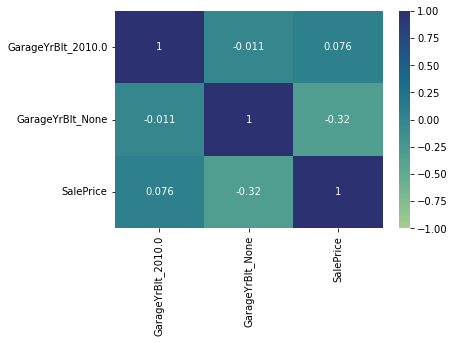

In [191]:
for i in range(0, len(X_train_encoded), 7):
    last = i + 7
    temp1 = X_train_encoded.iloc[:, i:last].merge(y_train_clean, how='inner', left_index=True, right_index=True)
    if len(temp1.columns) == 1:
        break
    sn.heatmap(temp1.corr(), vmin = -1, vmax = 1, annot=True, cmap = 'crest')
    plt.show()

### Correlation heat map - subset of variables

I plot the correlation heat map of the subset of variables that show a relationship with SalePrice to determine collinearity visually before building the models. I also ensure that any of the dummy variables are missing at least one of its associated dummy variables to ensure no collinearity. 

I have to remove the following variables since they were too closely correlated with another variable but had a lower absolute value correlation with SalePrice:
* SaleType_WD
* SaleCondition_Partial
* KitchenQual_Gd
* RoofStyle_Gable
* MSZoning_RL
* FireplaceQu_None
* GarageFinish_None
* GarageYrBlt_None
* GarageType_Attchd
* FullBath_2

#### Heat map results

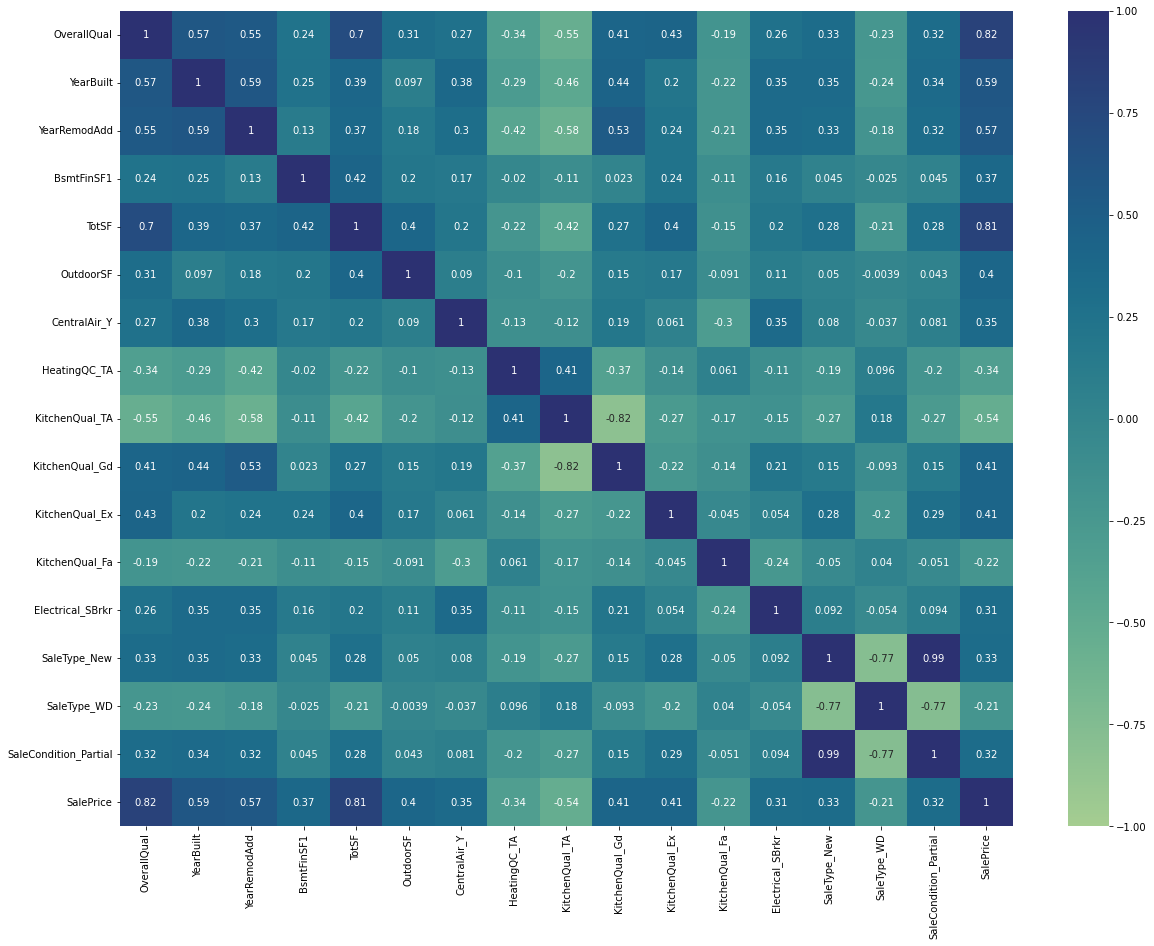

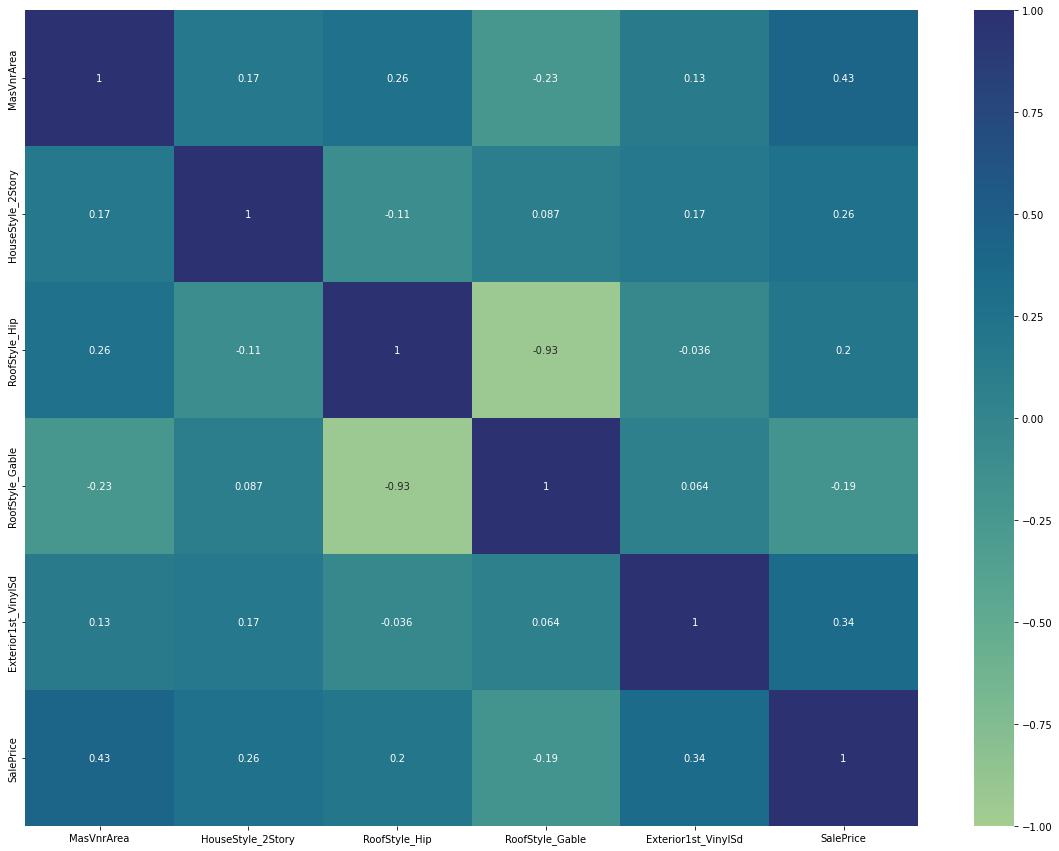

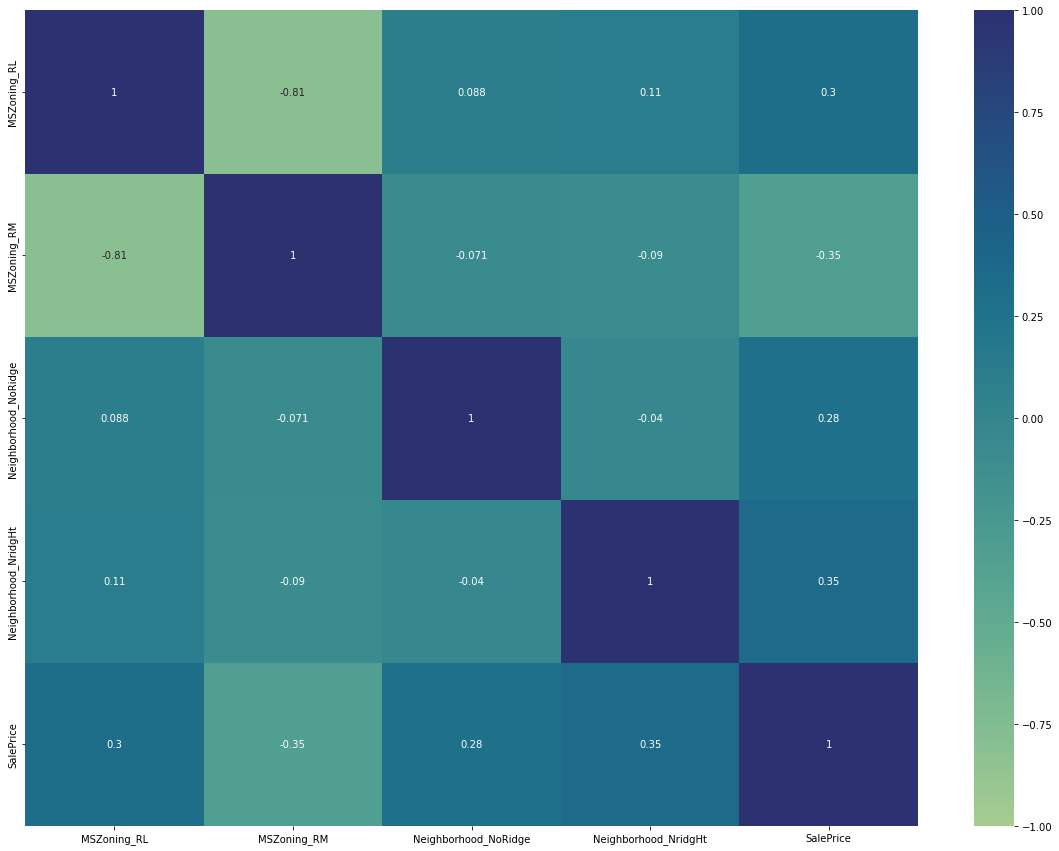

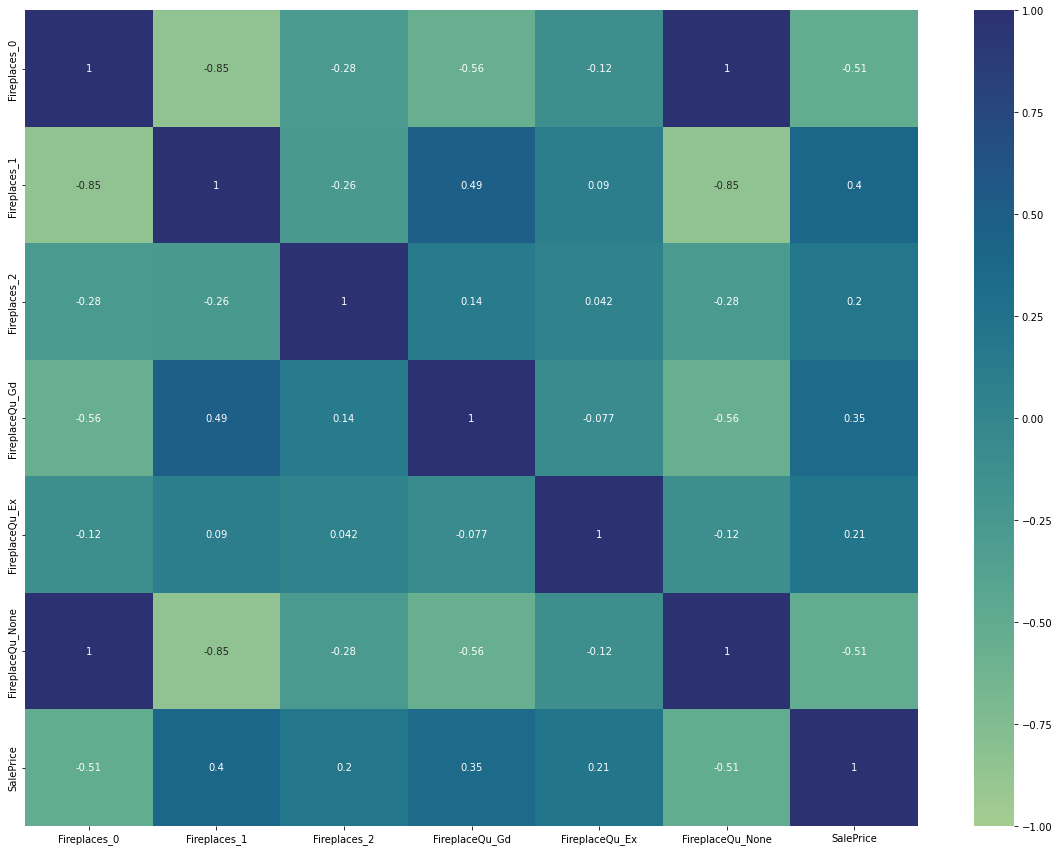

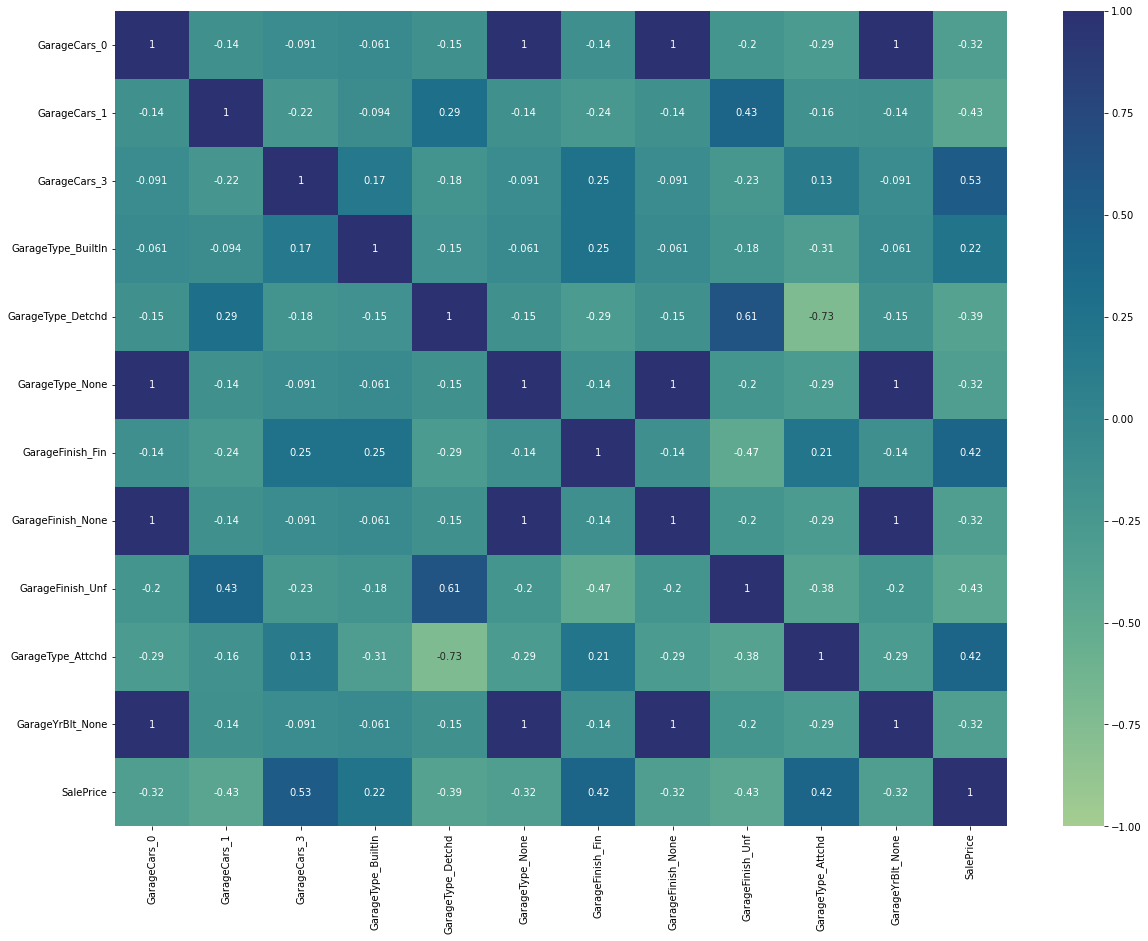

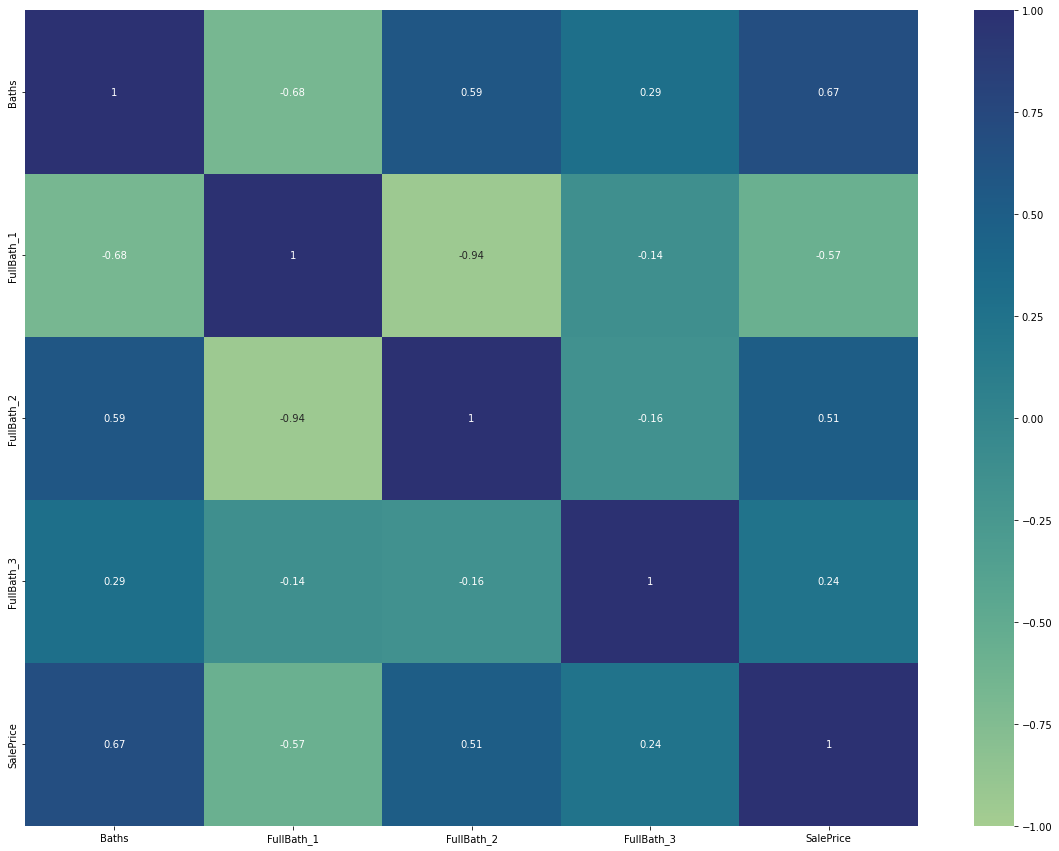

In [192]:
general_vars = ['OverallQual', 'YearBuilt', 'YearRemodAdd',  'BsmtFinSF1', 'TotSF',  'OutdoorSF', 'CentralAir_Y', 'HeatingQC_TA', 'KitchenQual_TA', 'KitchenQual_Gd', 
                'KitchenQual_Ex', 'KitchenQual_Fa', 'Electrical_SBrkr', 'SaleType_New', 'SaleType_WD', 'SaleCondition_Partial']
exterior_vars = ['MasVnrArea', 'HouseStyle_2Story', 'RoofStyle_Hip', 'RoofStyle_Gable', 'Exterior1st_VinylSd']
place_vars = ['MSZoning_RL', 'MSZoning_RM', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt']
fireplace_vars = ['Fireplaces_0', 'Fireplaces_1', 'Fireplaces_2', 'FireplaceQu_Gd', 'FireplaceQu_Ex', 'FireplaceQu_None']
garage_vars = ['GarageCars_0', 'GarageCars_1', 'GarageCars_3', 'GarageType_BuiltIn', 'GarageType_Detchd', 'GarageType_None', 'GarageFinish_Fin', 'GarageFinish_None', 'GarageFinish_Unf', 
               'GarageType_Attchd', 'GarageYrBlt_None']
bathroom_vars = ['Baths', 'FullBath_1', 'FullBath_2', 'FullBath_3']

for i in [general_vars, exterior_vars, place_vars, fireplace_vars, garage_vars, bathroom_vars]:
    temp1 = X_train_encoded[i]
    temp2 = temp1.merge(y_train_clean, how='inner', left_index=True, right_index=True)
    if len(temp2.columns) == 1:
        break
    plt.subplots(figsize=(20,15))
    sn.heatmap(temp2.corr(), vmin = -1, vmax = 1, annot=True, cmap = 'crest')
    plt.show()

In [193]:
X_train_encoded = X_train_encoded[['OverallQual', 'YearBuilt', 'YearRemodAdd',  'BsmtFinSF1', 'TotSF',  'OutdoorSF', 'CentralAir_Y', 'HeatingQC_TA', 'KitchenQual_TA', 
                                   'KitchenQual_Gd', 'KitchenQual_Ex', 'KitchenQual_Fa', 'Electrical_SBrkr', 'SaleType_New', 'SaleType_WD', 'SaleCondition_Partial', 
                                   'MasVnrArea', 'HouseStyle_2Story', 'RoofStyle_Hip', 'RoofStyle_Gable', 'Exterior1st_VinylSd','MSZoning_RL', 'MSZoning_RM', 
                                   'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Fireplaces_0', 'Fireplaces_1', 'Fireplaces_2', 'FireplaceQu_Gd', 'FireplaceQu_Ex', 
                                   'FireplaceQu_None', 'GarageCars_0', 'GarageCars_1', 'GarageCars_3', 'GarageType_BuiltIn', 'GarageType_Detchd', 'GarageType_None', 
                                   'GarageFinish_Fin', 'GarageFinish_None', 'GarageFinish_Unf', 'GarageType_Attchd', 'GarageYrBlt_None', 'Baths', 'FullBath_1', 
                                   'FullBath_2', 'FullBath_3']]

In [194]:
X_train_encoded.drop(['SaleType_WD','SaleCondition_Partial','KitchenQual_Gd','RoofStyle_Gable','MSZoning_RL', 'FireplaceQu_None',
                      'GarageFinish_None','GarageYrBlt_None','GarageType_Attchd','FullBath_2'], 
                     axis = 1, 
                     inplace = True)

## Modeling

I generate four different models. The first is a linear model without any interaction terms, the second is a linear model with interaction terms, the third is a linear model that has nonlinear componenets and no interaction terms and the last is a linear model that has nonlinear components and interation terms.

I first scale the variables that will be potentially used in the model. For the models with nonlinear components, I will evaluate polynomial, indicator, dichotomous, & piecewise model components.

After the models are genreated, I will check each of the models first for fit using R^2 and the F Statistic. Once I am satisfied that the grouping of independent variables have predictive power, I then check for collinearity using variance inflation factor, outliers using studentized residuals, high-leverage points using the leverage statistic. With each modification, I rerun R^2 and F statistic to track the progress of fit. 

Lastly, I then evaluate the assumptions of the model. I evaluate how each of the models satisfy (or not) linearity of the response-predictor relationships, uncorrelation of error terms, and constant variance of error terms. I make any last adjustments to the models before evaluating the fit one last time.

### Scaling

I consider two options for scaling, either Min-Max or Standard. Since we have so many categorical variables that were transformed into dummy variables, I choose Min-Max scaling. This allows me to include robustness to very small standard deviations of features and preserving zero entries in sparse data.

In [195]:
min_max_scaler = MinMaxScaler()

X_train_scaled = min_max_scaler.fit_transform(X_train_encoded)
y_train_scaled = min_max_scaler.fit_transform(y_train_clean)

#### Split between train and validation sets

In [196]:
X_train, X_test, y_train, y_test = train_test_split(X_train_scaled, y_train_scaled, test_size=0.3, random_state=0)

### Model A

First attempt uses all the potential variables. While the Adj. R^2 and F-Stat are good, we see we have some non-significant coefficients. Second attempt removes the non-significant coefficients.

In [197]:
X_train_a_1 = sm.add_constant(X_train)
model_a_1_est = sm.OLS(y_train, X_train_a_1)
model_a_1 = model_a_1_est.fit()
print(model_a_1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     194.5
Date:                Thu, 13 Jan 2022   Prob (F-statistic):               0.00
Time:                        14:11:56   Log-Likelihood:                 1685.6
No. Observations:                1022   AIC:                            -3299.
Df Residuals:                     986   BIC:                            -3122.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1703      0.033      5.155      0.0

Five - start the analysis of outliers, etc.

Took care of the multicollinearity warning, our R^2 went down a little but F stat is higher meaning...
Now need to run 

In [200]:
X_train_2 = np.delete(X_train, [1, 4, 10, 11, 13, 14, 15, 16, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 31, 32, 34, 35], axis = 1)

X_train_a_2 = sm.add_constant(X_train_2)
model_a_2_est = sm.OLS(y_train, X_train_a_2)
model_a_2 = model_a_2_est.fit()
print(model_a_2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     339.3
Date:                Thu, 13 Jan 2022   Prob (F-statistic):               0.00
Time:                        14:15:54   Log-Likelihood:                 1488.6
No. Observations:                1022   AIC:                            -2949.
Df Residuals:                    1008   BIC:                            -2880.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1706      0.012     14.363      0.0

In [87]:
model_a = LinearRegression().fit(X_train, y_train)

In [97]:
print('Intercept: {0}'.format(reg.intercept_))
print('R^2 Score: {0}'.format(model_a.score(X_train, y_train)))
print('MSE: {0}'.format())

Intercept: [-0.0407132]
R^2 Score: 0.8623709085670828


In [95]:
model_a_coef = pd.concat([pd.DataFrame(X_train_encoded.columns), pd.DataFrame(np.transpose(model_a.coef_))], axis = 1)
model_a_coef.columns = ['Coef Name', 'Coef']

In [96]:
model_a_coef

Coef Name      Coef
0            OverallQual  0.165934
1              YearBuilt  0.001614
2           YearRemodAdd  0.016151
3             BsmtFinSF1  0.088071
4                  TotSF  0.473181
5              OutdoorSF  0.035664
6           CentralAir_Y  0.009092
7           HeatingQC_TA -0.002565
8         KitchenQual_TA -0.008990
9         KitchenQual_Ex  0.039858
10        KitchenQual_Fa -0.005146
11      Electrical_SBrkr -0.000264
12          SaleType_New  0.024814
13            MasVnrArea  0.032640
14     HouseStyle_2Story  0.005844
15         RoofStyle_Hip  0.005530
16   Exterior1st_VinylSd  0.002637
17           MSZoning_RM -0.017701
18  Neighborhood_NoRidge  0.057033
19  Neighborhood_NridgHt  0.015352
20          Fireplaces_0 -0.009691
21          Fireplaces_1 -0.001569
22          Fireplaces_2  0.023692
23        FireplaceQu_Gd  0.003498
24        FireplaceQu_Ex  0.033531
25          GarageCars_0  0.000149
26          GarageCars_1  0.002256
27          GarageCars_3  0.024875
28    GarageType_BuiltIn  0.001415
29     GarageType_Detchd -0.000158
30       GarageType_None  0.000149
31      GarageFinish_Fin  0.007224
32      GarageFinish_Unf -0.001627
33                 Baths  0.035224
34            FullBath_1 -0.000245
35            FullBath_3  0.057374

In [ ]:
# start generating models with three vars and keep on adding and checking R^2 and F Statistic to verify models. Then create a function to generate the necessary plots/ stats
# for outliers, high leverage points

### Model B

### Model C

### Model D

## Conclusion

In [ ]:
# clf = svm.SVC(kernel='linear', C=1, random_state=42)
# scores = cross_val_score(clf, X, y, cv=5)
# scores
# https://scikit-learn.org/stable/modules/cross_validation.html